<h3>Encounter rate image analysis</h3>

This image-analysis pipeline was used to analyze the recorded videos from the encounter rate experiments. This script was developped within the framework of the following publication:

<em>de Schaetzen & Fan et al. Random encounters and predator locomotion drive the predation of Listeria monocytogenes by Acanthamoeba castellanii.</em>

In [1]:
#%% Import the correct libraries
from __future__ import division, unicode_literals, print_function  #for compatibility with Python 2 and 3
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import math 

from scipy import ndimage as ndi
import trackpy as tp
import trackpy.predict
from tifffile import imread
from tifffile import imsave
from skimage.feature import canny
from skimage.filters import sobel
from skimage.exposure import histogram
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import area_closing
from skimage import measure
from skimage.segmentation import random_walker as rw
from scipy.ndimage import gaussian_filter

<h4>Creating a folder structure for file saving</h4>

In [2]:
def_path = r'F:\Encounter rate experiment analysis\OD0.005_14082020\CONTROL'# Set the default folder, the folder mentioned here only serves as an example
# the following definition allows for easy folder creation:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## TIFF: in this folder the converted video files will be saved (the conversion happens in ImageJ/Fiji)
TIFF_path = def_path + "\TIFF"
createFolder(TIFF_path)
## SCALE: in this folder the rescaled video files will be saved
SCALE_path = def_path + "\SCALE"
createFolder(SCALE_path)
## DATA_FEAT : location in which feature .csv files will be saved
DAFE_path = def_path + "\DATA_FEAT"
createFolder(DAFE_path)
## DATA_TRAJ: location in which trajectory .csv files will be saved  
DATR_path = def_path + "\DATA_TRAJ"
createFolder(DATR_path)
## DATA_TRAJfilter: location in which trajectory .csv files will be saved  
DATR_f_path = def_path + "\DATA_TRAJ_filter"
createFolder(DATR_f_path)
## DATA_TRAJ_MSD: location in which MSD filtered trajectory .csv files will be saved  
DATR_MSD_path = def_path + "\DATA_TRAJ_MSD"
createFolder(DATR_MSD_path)   
## DATR_MSD_TC: location in which MSD files including translational component are saved
DATR_MSD_TC_path = def_path + "\DATA_TRAJ_MSD_TC"
createFolder(DATR_MSD_TC_path) 
## DATA_TRAJ_MSD_filter: location in which MSD filtered trajectory .csv files will be saved  
DATR_MSD_f_path = def_path + "\DATA_TRAJ_MSD_filter"
createFolder(DATR_MSD_f_path)        
## FIG_TRAJ: location in which trajectory plots will be saved  
FIGtraj_path = def_path + "\FIG_TRAJ"
createFolder(FIGtraj_path) 
## FIG_MSD_traj: location in which msd filtered trajectory plots will be saved  
FIG_MSD_traj_path = def_path + "\FIG_TRAJ_MSD_filter"
createFolder(FIG_MSD_traj_path)
## FIG_TRAJ: location in which trajectory plots will be saved  
FIGmsd_path = def_path + "\FIG_MSD"
createFolder(FIGmsd_path)   
## FIG_TRAJ: location in which trajectory plots will be saved  
FIG_TC_path = def_path + "\FIG_TC"
createFolder(FIG_TC_path)     
## CANNY_INTERACTION_path: folder in which videofiles containing the interaction masks will be saved
CANNY_INTERACTION_path = def_path + "\CANNY_INTERACTION"
createFolder(CANNY_INTERACTION_path)
## CANNY_INTERACTION_small_path: folder in which videofiles containing the small interaction masks will be saved
CANNY_INTERACTION_small_path = def_path + "\CANNY_INTERACTION_small"
createFolder(CANNY_INTERACTION_small_path)
## CANNY_AMOEBA: folder in which videofiles containing the amoeba masks will be saved
CANNY_AMOEBA_path = def_path + "\CANNY_AMOEBA"
createFolder(CANNY_AMOEBA_path)
## OUTPUT: folder in which global result data (amoeba_size, swimming speed, density,...) for all timepoints in .csv format will be saved
OUTPUT_path = def_path + "\OUTPUT"
createFolder(OUTPUT_path)

<h4>Rescaling video files to 8-bit with a custom conversion</h4>

It is assumed that the video-files have been converted from 16-bit .ND2 to 16-bit .TIFF. This can be done using the batch convert tool within ImageJ/Fiji (Process > Batch > Convert). Make sure to place the converted files into the TIFF folder.

- RAW video files were named with their timestap, but always with 2 digits (e.g. for the recording in minute 1 the file would have had the name 01.nd2). This naming protocol is used throughout the script to assign timelabels in different resulting tables.

In [27]:
fl_TIFF = os.listdir(TIFF_path)
os.chdir(TIFF_path)
i = 1 # step variable
R_mid = 125 # the center 8-bit value around which all pixel values will be centered
R_min = 0 # the minimum value of an 8-bit range
R_max = 255 # the maximum value of an 8-bit range
i = 1 # step variable
for value in fl_TIFF: # for loop that will cycle through each video-file
    os.chdir(TIFF_path) # set the working directory to the TIFF folder 
    frames = np.array(imread(value)) # import the video-file as a numpy array
    frames = frames/2.5 # the division of all pixel values by a factor 2.5 drastically reduces noise levels in the resulting rescaled videos
    median = np.median(frames) # calculate the median value of all pixels over all frames
    shift = median - R_mid # calculate pixel shift value that centers pixel values around 125
    frames = frames - shift # deduct the pixel shift value to all pixels in all frames
    frames = np.where(frames < R_min, R_min, frames) # all pixel values lower than R_min will be set to R_min 
    frames = np.where(frames > R_max, R_max, frames) # all pixel values higher than R_max will be set to R_max
    scale_frames = np.array(frames, dtype = np.uint8) # convert the rescaled frames from 32-bit to 8 bit 
    os.chdir(SCALE_path) # set the working directory to the SCALE folder 
    filename_scaled = value.replace('.tif','_scaled.tif') # create a new filename
    imsave(filename_scaled, scale_frames, imagej = 'True') # save the rescaled frames
    print(i, 'out of', len(fl_TIFF), ' .TIFF files have been rescaled')
    i += 1;  

1 out of 3  .TIFF files have been rescaled
2 out of 3  .TIFF files have been rescaled
3 out of 3  .TIFF files have been rescaled


<h4>Canny edge detection with several morphological operators opencv ans scipy to calculate a mask of the amoeba</h4>

The following part of the script will only work on the video-files produced by the previous script block titled: 'Rescaling video files to 8-bit with a custom conversion'. The resulting interaction mask extends approximately 4 micrometers from the edge of the recorded Acanthamoeba, which in turn is represented by the Amoeba  mask. The Amoeba mask allows for the removal of the Acanthamoeba during the TrackPy particle detection. 

In [6]:
os.chdir(SCALE_path) # set the working directory to the SCALE folder
fl_SCALE = os.listdir(SCALE_path) # make a list of all filenames
i = 1 # step variable
for value in fl_SCALE: # for loop that will cycle through each video-file 
    os.chdir(SCALE_path) # set the working directory to the SCALE folder
    frames = np.array(imread(value)) # import the video-file as a numpy array
    stacksize = len(frames) # calculate the total amount of frames
    fr = 0 # step variable
    INTERACTION = [] # create an empty list
    INTERACTION_small = [] # create an empty list
    AMOEBA = [] # create an empty list
    while fr <= stacksize - 1: # a while loop that will go through each frame (the -1 modifier is in place to correct for the startframe value of 0)
        sub_frame = frames[fr,::] # select the respective frame to be processed
        sub_frame = gaussian_filter(sub_frame, sigma = 1.5) # apply a Gaussian blur with a kernel size of 1.5 pixels
        conv_kernel = np.array([[-1, -1, -1],[-1, 5, -1],[-1, -1, -1]]) # define a convolution kernel
        conv_frame = ndi.convolve(sub_frame, conv_kernel, mode='reflect', cval=0.0) # apply the convolution kernel to the frame
        canny_frame = cv2.Canny(conv_frame, 20, 200) # apply a wide canny edge detection 
        ## Dilate the detected edges
        dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)) # define the dilation kernel
        dilate_frame = np.array(cv2.dilate(canny_frame, dilate_kernel, iterations = 1), dtype = np.uint8) # dilate the detected edges (this fattens the detected edges)
        ## Fill gaps, this will create blobs one of which is the observed amoeba
        close_frame = np.array(ndi.binary_fill_holes(dilate_frame), dtype = np.uint8) # fills the gaps in between the edges
        close_frame[close_frame > 0] = 255 # convert all pixels with a value above 0 to 255
        ## Apply the opening morphological operation to remove unwanted objects
        opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(80,80)) # define the opening kernel
        opening_frame = cv2.morphologyEx(close_frame, cv2.MORPH_OPEN, opening_kernel) # apply the opening morphological operation to remove unwanted objects
        ## Dilate the remaining amoeba feature - this will be the interaction mask
        dilation2_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) # define the dilation2 kernel
        dilation2_frame = cv2.dilate(opening_frame, dilation2_kernel, iterations = 1) # dilate the remaining amoeba feature
        INTERACTION.append(dilation2_frame) # collect all interaction mask frames into one list
        ## Erode the remaining amoeba feature - this will be the Amoeba mask
        erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30, 30)) # define the erosion kernel
        erosion_frame = cv2.erode(dilation2_frame, erosion_kernel, iterations = 1) # erode the the remaining amoeba feature
        AMOEBA.append(erosion_frame) # collect all amoeba mask frames into one list 
        ## Diltate the remaining amoeba feature - this will be the Interaction small mask (this mask is 50% smaller than the normal interaction mask)
        dilation3_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15, 15)) # define the dilation kernel
        dilation3_frame = cv2.dilate(erosion_frame, dilation3_kernel, iterations = 1) # dilate the amoeba mask
        INTERACTION_small.append(dilation3_frame) # collect all small interaction mask frames into one list 
        fr += 1 # increase the frame step variable with 1
    INTERACTION = np.array(INTERACTION) # convert the list to a numpy array
    filename_interaction = os.path.splitext(value[0:4])[0] + "_interaction.tif" # create a new filename
    os.chdir(CANNY_INTERACTION_path) # set the working directory to the CANNY_INTERACTION folder  
    imsave(filename_interaction, INTERACTION,  imagej = 'True') # save the interaction mask video file as an ImageJ compatible .tif file
    AMOEBA= np.array(AMOEBA) # convert the list to a numpy array
    filename_amoeba = os.path.splitext(value[0:4])[0] + "_amoeba.tif" # create a new filename
    os.chdir(CANNY_AMOEBA_path) # set the working directory to the CANNY_AMOEBA folder  
    imsave(filename_amoeba, AMOEBA,  imagej = 'True') # save the amoeba mask video file as an ImageJ compatible .tif file
    INTERACTION_small = np.array(INTERACTION_small) # convert the list to a numpy array
    filename_interactionsmall = os.path.splitext(value[0:4])[0] + "_interaction_small.tif" # create a new filename
    os.chdir(CANNY_INTERACTION_small_path) # set the working directory to the INTERACTION small folder
    imsave(filename_interactionsmall, INTERACTION_small,  imagej = 'True') # save the small interaction mask file as an ImageJ compatible .tif file
    print(i, 'out of', len(fl_SCALE), '.tif files have been processed for an interaction and amoeba mask')
    i += 1; # increase the step variable

1 out of 196 .tif files have been processed for an interaction and amoeba mask
2 out of 196 .tif files have been processed for an interaction and amoeba mask
3 out of 196 .tif files have been processed for an interaction and amoeba mask
4 out of 196 .tif files have been processed for an interaction and amoeba mask
5 out of 196 .tif files have been processed for an interaction and amoeba mask
6 out of 196 .tif files have been processed for an interaction and amoeba mask
7 out of 196 .tif files have been processed for an interaction and amoeba mask
8 out of 196 .tif files have been processed for an interaction and amoeba mask
9 out of 196 .tif files have been processed for an interaction and amoeba mask
10 out of 196 .tif files have been processed for an interaction and amoeba mask
11 out of 196 .tif files have been processed for an interaction and amoeba mask
12 out of 196 .tif files have been processed for an interaction and amoeba mask
13 out of 196 .tif files have been processed for 

104 out of 196 .tif files have been processed for an interaction and amoeba mask
105 out of 196 .tif files have been processed for an interaction and amoeba mask
106 out of 196 .tif files have been processed for an interaction and amoeba mask
107 out of 196 .tif files have been processed for an interaction and amoeba mask
108 out of 196 .tif files have been processed for an interaction and amoeba mask
109 out of 196 .tif files have been processed for an interaction and amoeba mask
110 out of 196 .tif files have been processed for an interaction and amoeba mask
111 out of 196 .tif files have been processed for an interaction and amoeba mask
112 out of 196 .tif files have been processed for an interaction and amoeba mask
113 out of 196 .tif files have been processed for an interaction and amoeba mask
114 out of 196 .tif files have been processed for an interaction and amoeba mask
115 out of 196 .tif files have been processed for an interaction and amoeba mask
116 out of 196 .tif files ha

In [3]:


os.chdir(CANNY_AMOEBA_path) # set the working directory to the AMOEBA folder
fl_AMOEBA = os.listdir(CANNY_AMOEBA_path) # creata a list of all filenames
i = 1 # step variable
for value in fl_AMOEBA: # for loop that will cycle through each video-file 
    os.chdir(CANNY_AMOEBA_path) # set the working directory to the AMOEBA folder
    frames = np.array(imread(value)) # import the video-file as a numpy array
    stacksize = len(frames) # calculate the total amount of frames
    fr = 0 # the frame step variable
    INTERACTION_small = [] # create an empty list
    while fr <= stacksize - 1: # a while loop that will go through each frame (the -1 modifier is in place to correct for the startframe value of 0)
        sub_frame = frames[fr,::] # select the respective frame to be processed
        dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15, 15)) # define the dilation kernel
        dilation_frame = cv2.dilate(sub_frame, dilation_kernel, iterations = 1) # dilate the amoeba mask
        INTERACTION_small.append(dilation_frame) # collect all small interaction mask frames into one list 
        fr += 1 # increase the frame step variable
    INTERACTION_small = np.array(INTERACTION_small) # convert the list to a numpy array
    filename_interactionsmall = value.replace('_amoeba.tif', '_interaction_small.tif') # create a new filename
    os.chdir(CANNY_INTERACTION_small_path) # set the working directory to the INTERACTION small folder
    imsave(filename_interactionsmall, INTERACTION_small,  imagej = 'True') # save the small interaction mask file as an ImageJ compatible .tif file
    print(i, 'out of', len(fl_AMOEBA), '.tif files have been processed for a small interaction mask')
    i+=1;



1 out of 60 .tif files have been processed for a small interaction mask
2 out of 60 .tif files have been processed for a small interaction mask
3 out of 60 .tif files have been processed for a small interaction mask
4 out of 60 .tif files have been processed for a small interaction mask
5 out of 60 .tif files have been processed for a small interaction mask
6 out of 60 .tif files have been processed for a small interaction mask
7 out of 60 .tif files have been processed for a small interaction mask
8 out of 60 .tif files have been processed for a small interaction mask
9 out of 60 .tif files have been processed for a small interaction mask
10 out of 60 .tif files have been processed for a small interaction mask
11 out of 60 .tif files have been processed for a small interaction mask
12 out of 60 .tif files have been processed for a small interaction mask
13 out of 60 .tif files have been processed for a small interaction mask
14 out of 60 .tif files have been processed for a small inte

<h4>Calculate the size and radius of the Amoeba based on the Amoeba mask</h4>

Here we make the assumption that the amoeba has a circular shape with a constant radius. The reason for this assumption is that the encounter rate models we used to compare out excperimental data with, use a the geometries of a circle or half sphere with a constant radius

- this script block was skipped for the CONTROL folder as there is no need to calculate theoretical encounter rates, since there was no amoeba present.

In [10]:
os.chdir(CANNY_AMOEBA_path) # set the working directory to the AMOEBA folder
fl_AMOEBA = os.listdir(CANNY_AMOEBA_path) # create a list of all filenames 
pmc = 3.076923 # pixel per micrometer conversion factor (this was determined by the microscope and remained constant for all encounter rate experiments, since they were all performed on one microscope with constant paramters)
pmc2 = pmc*pmc # square pixels per square micrometer conversion factor
i = 1 # step variable
amoeba_size = pd.DataFrame(columns = ['time','amoeba_label', 'area_amoeba', 'radius_amoeba', 'area_interaction', 'radius_interaction', 'area_interaction_small', 'radius_interaction_small'])
for value in fl_AMOEBA: # for loop that will cycle through each filename
    timepoint = os.path.splitext(value[0:2])[0] # define the timpoint based on the filename
    amoeba_label = os.path.splitext(value[3])[0] # define the amoeba labal based on the filename
    ## calculate the area and radius of the AMOEBA mask
    os.chdir(CANNY_AMOEBA_path) # set the working directory to the AMOEBA folder
    frames_amoeba = np.array(imread(value)) # import the AMOEBA mask files as a numpy array
    stacksize = len(frames_amoeba)  # calculate the total amount of frames
    area_amoeba = (np.count_nonzero(frames_amoeba == 255)/stacksize)/pmc2 # calculate the average area of the observed amoeba, based on the AMOEBA mask
    radius_amoeba = math.sqrt(area_amoeba/math.pi) # calculate the radius of the AMOEBA mask, assuming it is a circle
    ## calculate the area and radius of the INTERACTION mask
    filename_interaction = os.path.splitext(value[0:4])[0] + "_interaction.tif" # define the INTERACTION mask filename
    os.chdir(CANNY_INTERACTION_path) # set the working directory to the INTERACTION folder
    frames_interaction = np.array(imread(filename_interaction)) # import the INTERACTION mask file as a numpy array
    area_interaction = (np.count_nonzero(frames_interaction == 255)/stacksize)/pmc2 # calculate the average area of the INTERACTION mask
    radius_interaction = math.sqrt(area_interaction/math.pi) # calculate the radius of the INTERACTION mask, assuming it is a circle
    ## calculate the area and radius of the small INTERACTION  mask 
    filename_interaction_small = os.path.splitext(value[0:4])[0] + "_interaction_small.tif" # define the interaction mask filename
    os.chdir(CANNY_INTERACTION_small_path) # set the working directory to the INTERACTION_small folder
    frames_interaction_small = np.array(imread(filename_interaction_small)) # import the small INTERACTION mask file as a numpy array
    area_interaction_small = (np.count_nonzero(frames_interaction == 255)/stacksize)/pmc2 # calculate the average area of the small INTERACTION mask
    radius_interaction_small = math.sqrt(area_interaction_small/math.pi) # calculate the radius of the small INTERACTION mask, assuming it is a circle
    values = [(timepoint, amoeba_label, area_amoeba, radius_amoeba, area_interaction, radius_interaction, area_interaction_small, radius_interaction_small)] # create a list of all processed values
    sub_amoeba_size = pd.DataFrame(values, columns = ['time','amoeba_label', 'area_amoeba', 'radius_amoeba', 'area_interaction', 'radius_interaction', 'area_interaction_small', 'radius_interaction_small']) # transform the data into a DataFrame row
    amoeba_size = amoeba_size.append(sub_amoeba_size, sort = False) # collect all rows into one DataFrame
    print(i, 'out of', len(fl_AMOEBA), ' files have been processed for amoeba size and radius')
    i += 1;
os.chdir(OUTPUT_path) # set the working directory to the OUTPUT folder
amoeba_size.to_csv('amoeba_size.csv') # save the amoeba_size DataFrame as a .csv file

1 out of 60  files have been processed for amoeba size and radius
2 out of 60  files have been processed for amoeba size and radius
3 out of 60  files have been processed for amoeba size and radius
4 out of 60  files have been processed for amoeba size and radius
5 out of 60  files have been processed for amoeba size and radius
6 out of 60  files have been processed for amoeba size and radius
7 out of 60  files have been processed for amoeba size and radius
8 out of 60  files have been processed for amoeba size and radius
9 out of 60  files have been processed for amoeba size and radius
10 out of 60  files have been processed for amoeba size and radius
11 out of 60  files have been processed for amoeba size and radius
12 out of 60  files have been processed for amoeba size and radius
13 out of 60  files have been processed for amoeba size and radius
14 out of 60  files have been processed for amoeba size and radius
15 out of 60  files have been processed for amoeba size and radius
16 o

<h4>Particle recognition and trajectory formation</h4>

For more information regarding the TrackPy, we refer to the in-depth information provided by the TrackPy team on their github: http://soft-matter.github.io/trackpy/v0.5.0/. Furthermore, prior to the next analyses steps, the TrackPy parameters should be determined using the ACLI_TrackPy_parameterization script which can be found in the following github repository: https://github.com/Renderfarm/Acanthamoeba-Listeria. Please ensure that you run the parametization scriptblocks that apply for the encounter rate experiments!

In [12]:
os.chdir(SCALE_path) # set the working directory to the SCALE folder
FL_SCALE = os.listdir(SCALE_path) # create a list of all filenames
i = 1 # step variable
Dia = 11 # diameter: approximate diameter (in pixels) of the particles to be located
MinMass = 600 # Minimum mass: the minimum integrated brightness/darkness (filter to remove spurious objects)
MaxMass = 2000 # The maximum integrated brightness
Nsize = 1.5 # Noise size: width of the gaussian blur filter to remove noise
MaxDia = 21 # maximum diameter size (in pixels) of the particles to be located
sep = 7 # minumum separation (in pixels) between two features
Pmem = 17 # Particle memory: the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle, this correlated with 1 sec
TrackTresh = 17 # Minimum number of points (video frames) to survive, this correlated with 1 sec
MaxT = 10 # Maximum amount of pixels a bacteria can move in between two consecutive frames
for value in FL_SCALE:  # for loop that will cycle through each video-file
    os.chdir(SCALE_path) # set the working directory to the SCALE folder
    frames = np.array(imread(value)) # import the frames as a numpy array
    stacksize = len(frames) # calculate the total amount of frames
    ## Batch locate particles in each frame of the stack with tp.batch(array, diameter, maxsize, invert = True, noise_size, minmass, separation)
    fe = tp.batch(frames,  diameter = Dia, maxsize = MaxDia, invert = True, noise_size = Nsize, minmass = MinMass, separation = sep);
    fe.drop(fe[fe['mass'] >= MaxMass].index, inplace = True) # filter out particles which integrated Mass exceeds 2000
    # filter out useless detected features in Amoeba area frame per frame 
    fr = 0 # frame step variable
    mask = [] # create an empty list 
    os.chdir(CANNY_AMOEBA_path) # set the working directory to the AMOEBA folder
    filename_amoeba = value.replace('_scaled.tif', '_amoeba.tif') # create the corresponding AMOEBA mask filename
    frames_amoeba = np.array(imread(filename_amoeba)) # import the AMOEBA mask file as a numpy array
    if len(fe) == 0: 
        continue
    else:
        for fr in fe.frame.unique(): # for loop that cycles through each frame
            frame_data = fe.loc[fe['frame'] == fr] # select feature data for given frame fr
            frame_amoeba = frames_amoeba[fr,::] # select the corresponding AMOEBA mask frame fr
            frame_index = list(frame_data[["y", "x"]].round().astype(int).itertuples(index=False, name=None)) # get list of coordinates of features within frame (rounded upwards and transformed to integer for use in numpy)
            frame_mask = np.array([frame_amoeba[b] for b in frame_index]) # creates an array with pixel values of either 0, i.e. outside, or 255 , i.e. within the amoeba area/mask
            mask.extend(frame_mask) # collect all mask frames in one list
        mask = np.array(mask) # transform list to numpy array
        fe['mask'] = mask # add mask list as new column into feature dataset
        fe.drop(fe[fe['mask'] == 255].index, inplace = True) # drop rows with mask value 255 (within amoeba area), this will remove features that were detected within the amoeba area
        fe.drop(['mask'], axis = 1) # drop the mask collumn for future usage
    os.chdir(DAFE_path) # set the working directory to the DATA_FEAT folder
    filename_features = value.replace('_scaled.tif', '_feat.csv') # create a new filename
    pd.DataFrame(fe).to_csv(filename_features) # save the features DataFrame as a .csv file
    ## predictive link for trajectory plotting
    pred = trackpy.predict.NearestVelocityPredict() # activate the predictive tracking feature of TrackPy
    tr = pred.link_df(fe, search_range = MaxT, memory = Pmem) # start memory with 1, increase if disconnected paths for same cell
    os.chdir(DATR_path) # set the working directory to the DATA_TRAJ folder
    filename_traj = value.replace('_scaled.tif', '_traj.csv') # create a new filename
    pd.DataFrame(tr).to_csv(filename_traj)  # save the trajectories DataFrame as a .csv file
    ## filter out trajectories that are less than 17 frames long, this is approximately 1 second 
    trf = tp.filter_stubs(tr, TrackTresh) # filter out trajectories based on TrackTresh
    filename_trajfilter = value.replace('_scaled.tif', '_trajfilter.csv')
    os.chdir(DATR_f_path) # set the working directory to the DATA_TRAJ_filter folder
    pd.DataFrame(trf).to_csv(filename_trajfilter) # save the filtered trajectories DataFrame as a .csv file
    ## Plot of trajectories colored by particle
    plt.figure(figsize = (5,5), dpi = 300) # create an empty plot
    ax1 = plt.subplot(1,1,1) # add axes to the plot
    plt.imshow(frames[int(stacksize/2)], cmap = 'Greys_r' , vmin = 0, vmax = 255) # add the middle frame as a background image
    tp.plot_traj(trf, ax=ax1,colorby = 'particle') # plot the trajectories
    plotname_traj = value.replace('_scaled.tif', '_traj.tif') # create a plotname
    os.chdir(FIGtraj_path)
    plt.savefig(plotname_traj, format = 'tif', dpi = 300)    

C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\trackpy\feature.py:600: UserWarning: No maxima found in any frame.
  warnings.warn("No maxima found in any frame.")


Frame 1998: 0 features


<h4>Mean squared displacement (MSD) + translational component calculations</h4>

1 out of 59  files have been analyzed for msd and tc
2 out of 59  files have been analyzed for msd and tc
3 out of 59  files have been analyzed for msd and tc
4 out of 59  files have been analyzed for msd and tc
5 out of 59  files have been analyzed for msd and tc
6 out of 59  files have been analyzed for msd and tc
7 out of 59  files have been analyzed for msd and tc
8 out of 59  files have been analyzed for msd and tc
9 out of 59  files have been analyzed for msd and tc
10 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


11 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


12 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


13 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


14 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


15 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


16 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


17 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


18 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


19 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


20 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


22 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

23 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


24 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

25 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


26 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


27 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


28 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

29 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


30 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


31 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


32 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

33 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


34 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

35 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


36 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


37 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


38 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

39 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


40 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


41 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


42 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

43 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


44 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


45 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


46 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

47 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


48 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


49 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

50 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


51 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

52 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


53 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


54 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


55 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed

56 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


57 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


58 out of 59  files have been analyzed for msd and tc


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


59 out of 59  files have been analyzed for msd and tc


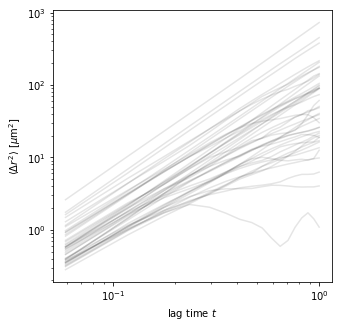

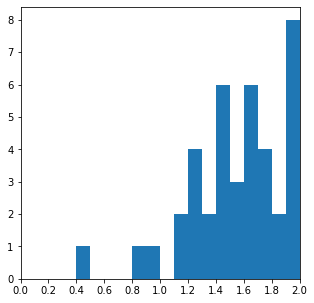

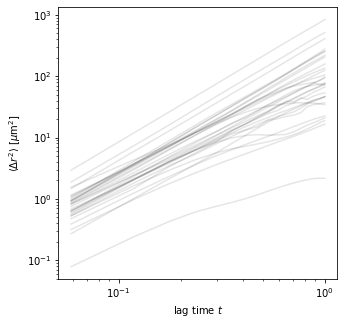

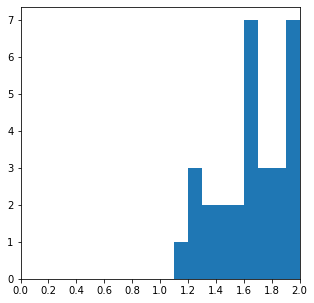

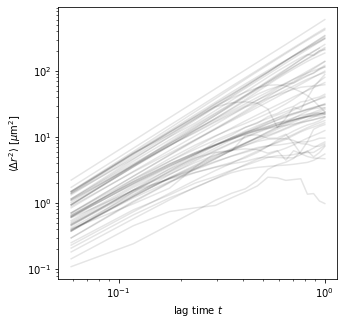

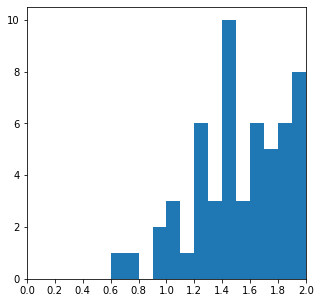

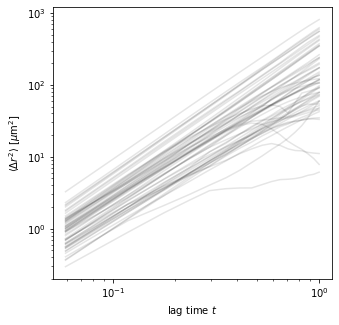

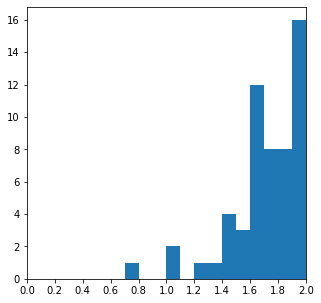

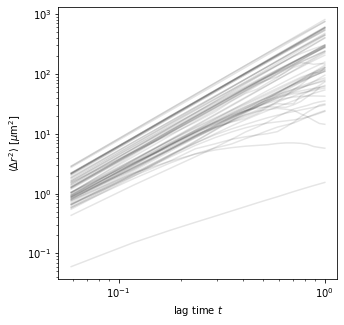

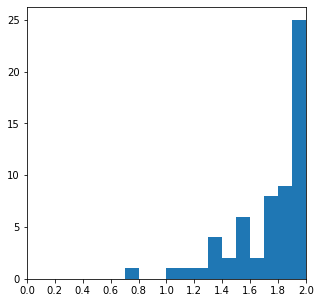

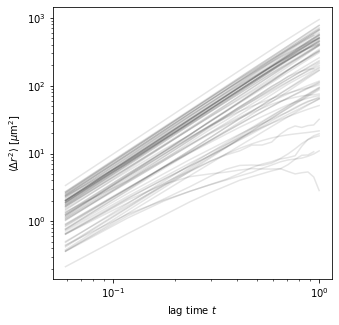

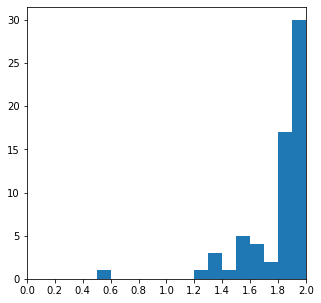

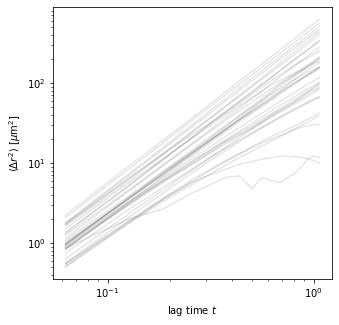

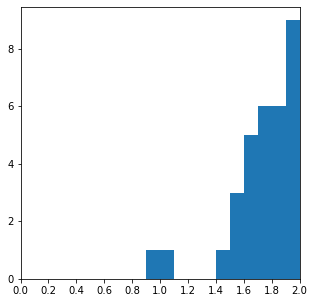

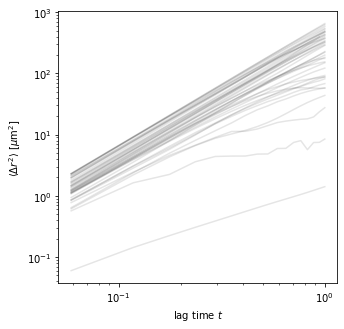

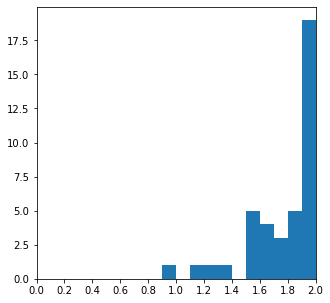

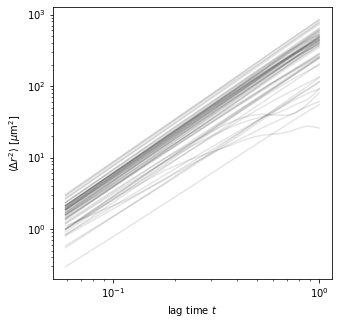

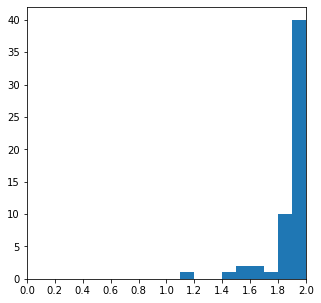

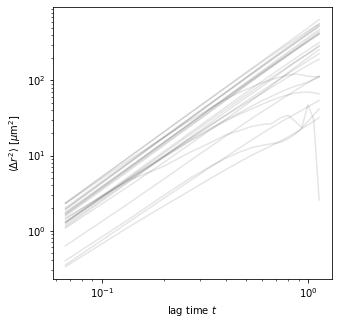

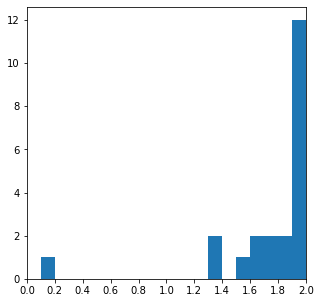

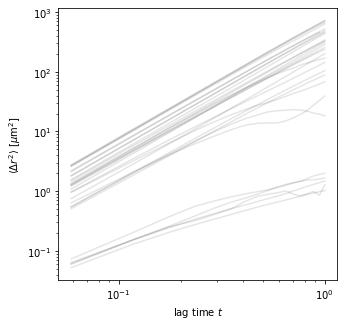

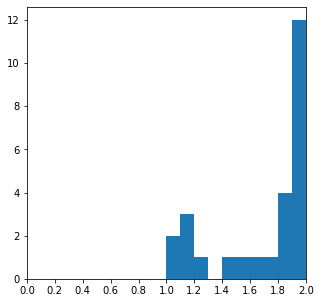

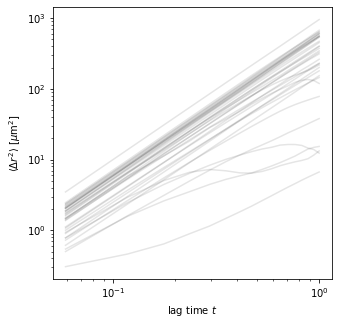

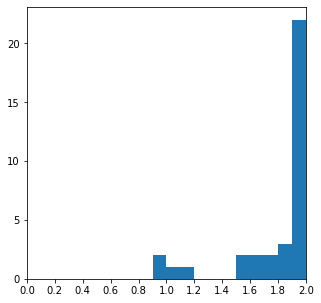

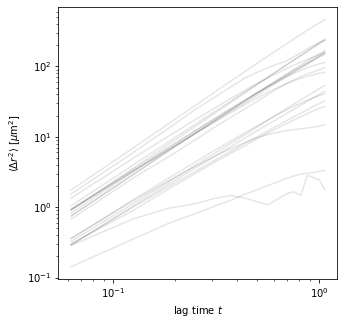

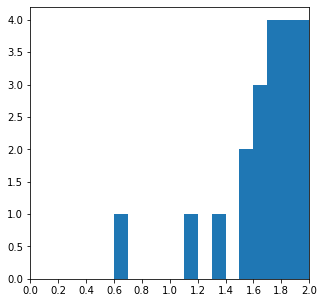

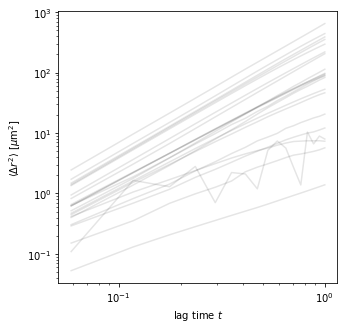

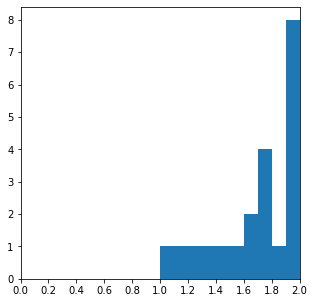

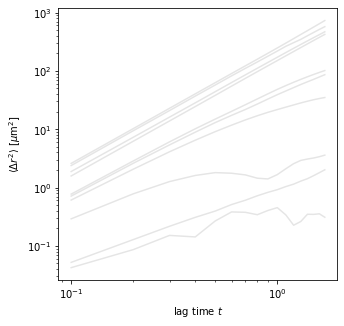

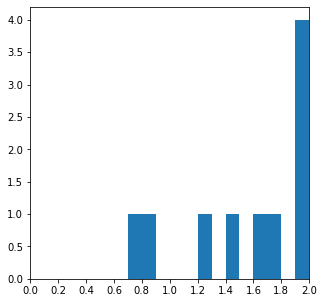

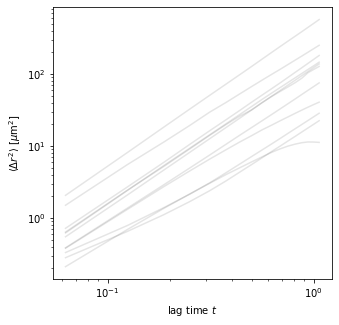

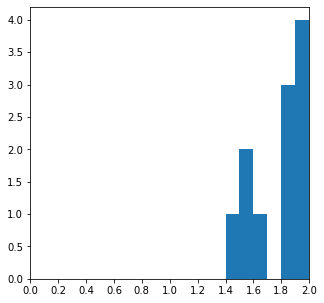

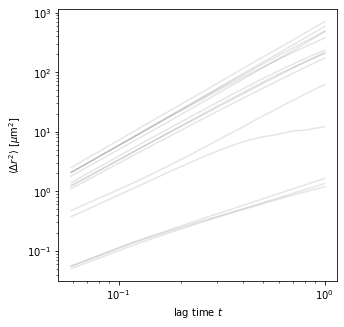

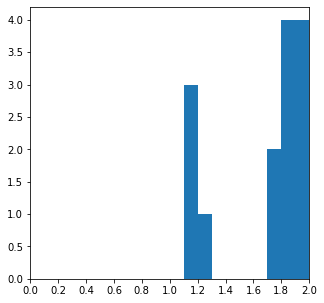

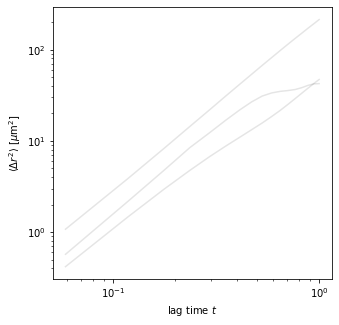

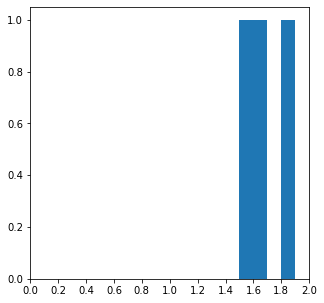

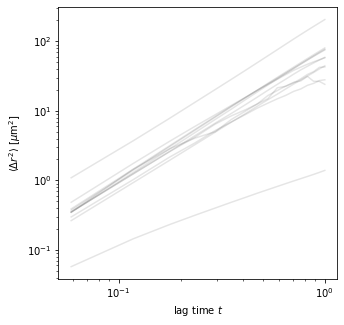

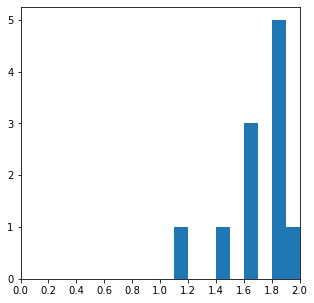

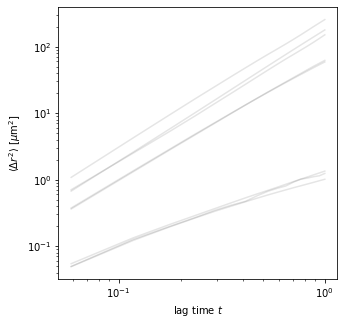

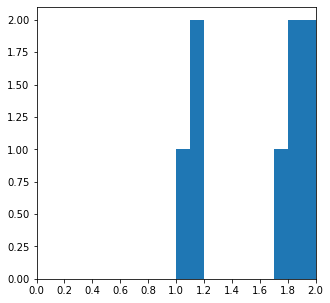

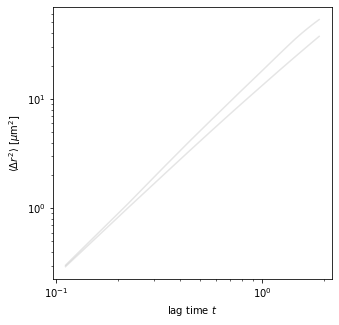

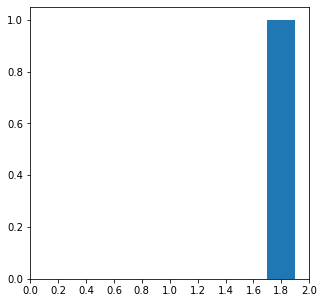

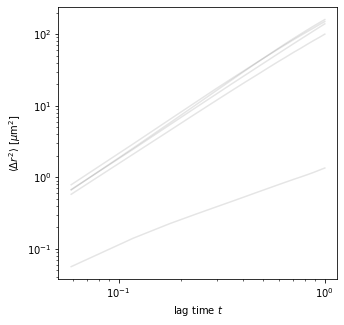

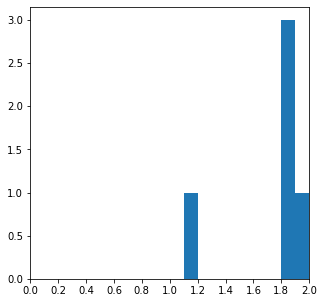

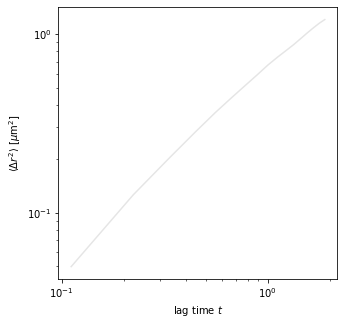

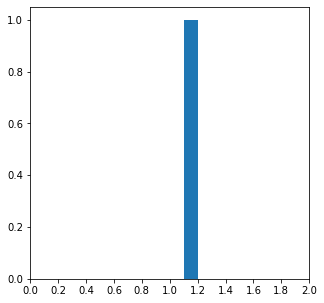

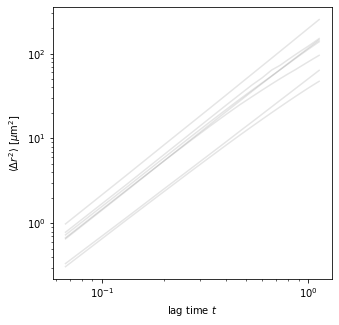

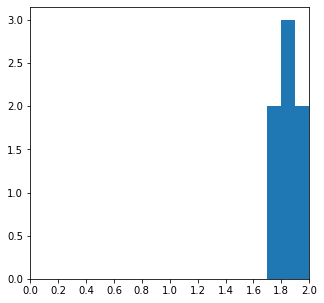

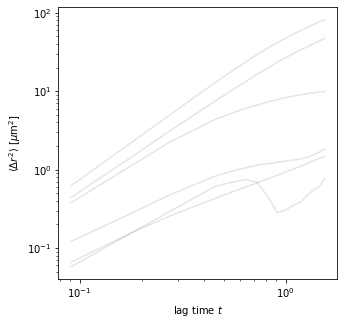

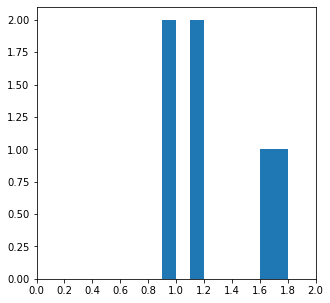

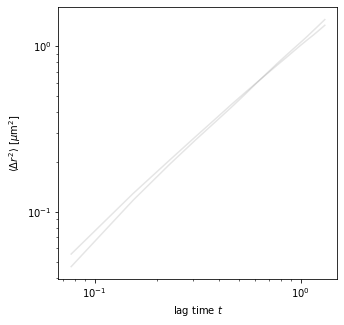

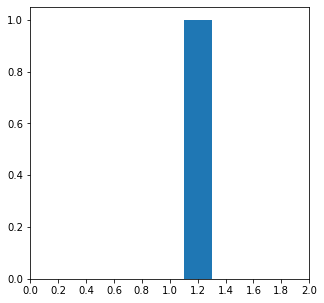

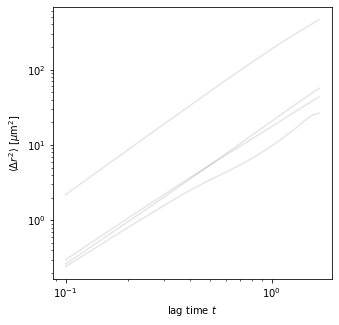

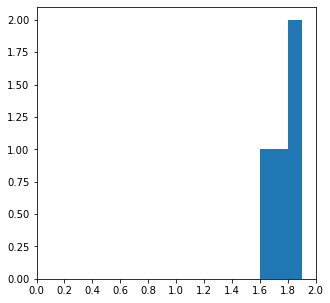

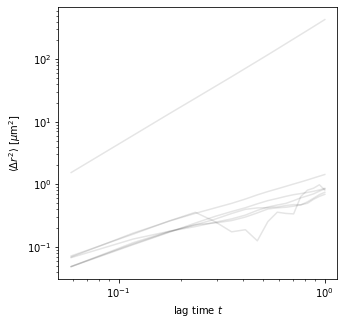

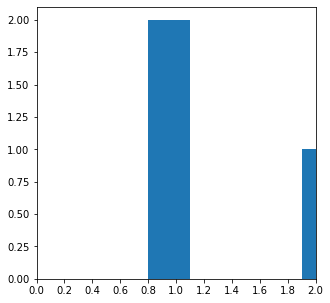

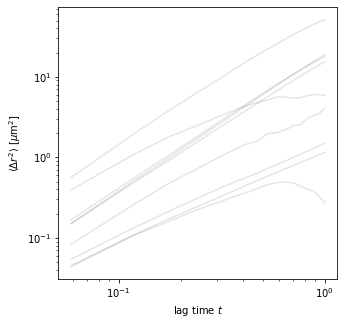

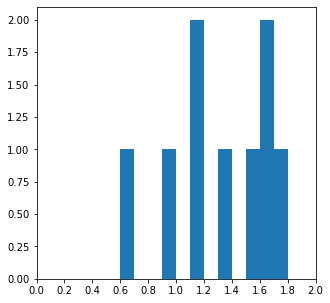

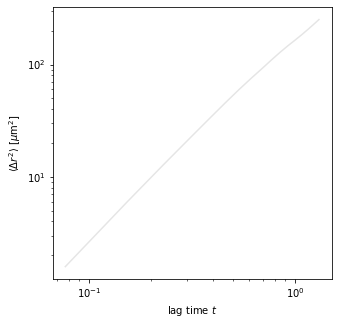

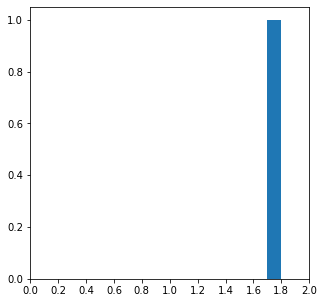

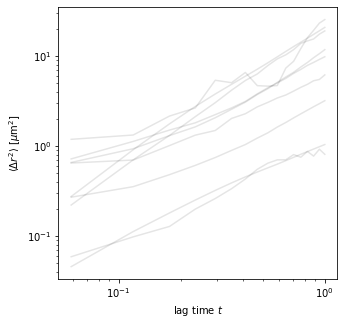

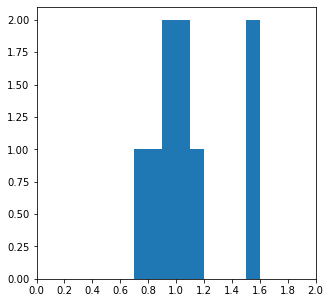

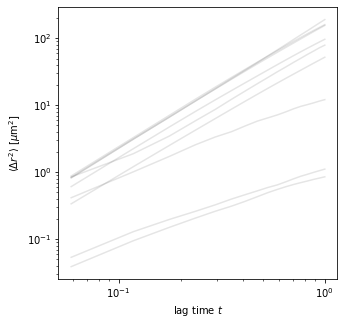

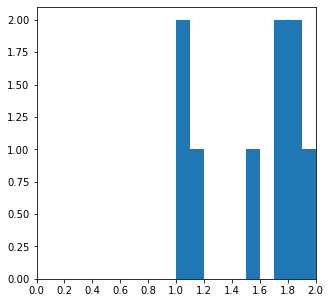

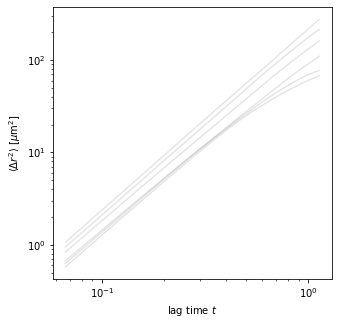

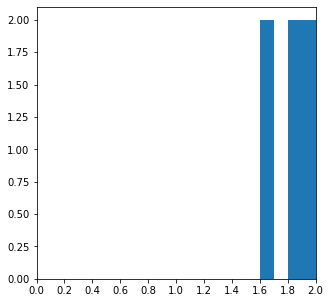

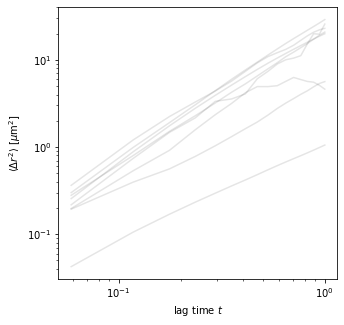

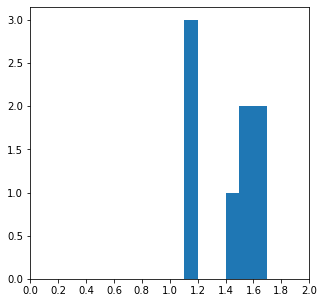

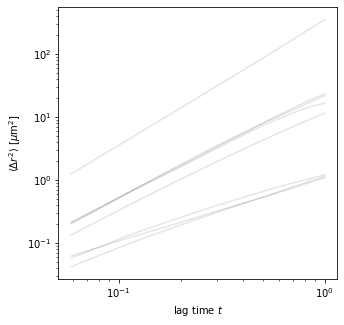

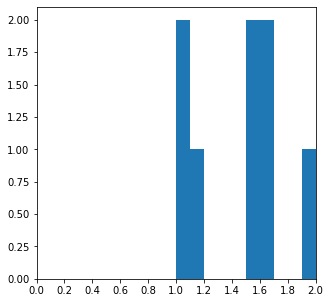

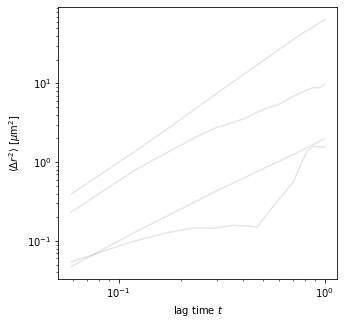

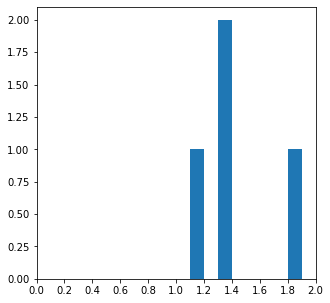

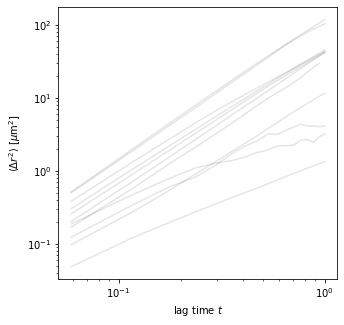

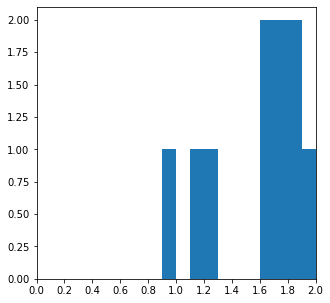

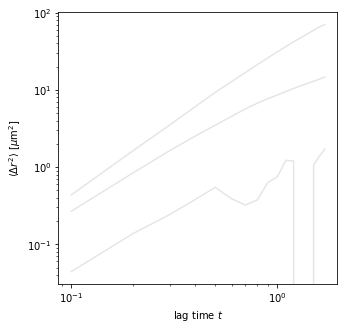

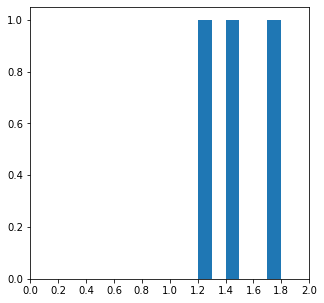

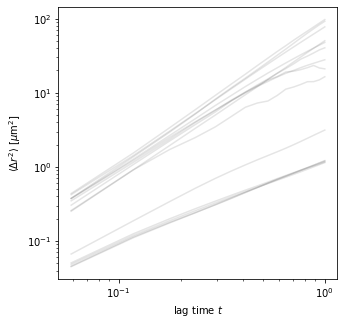

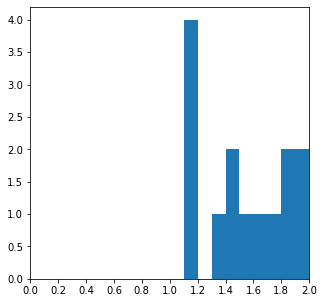

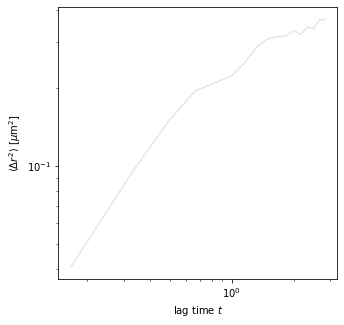

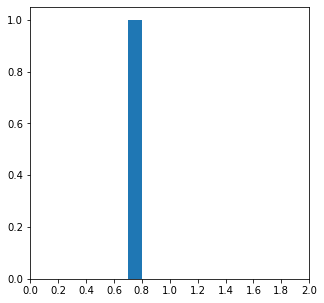

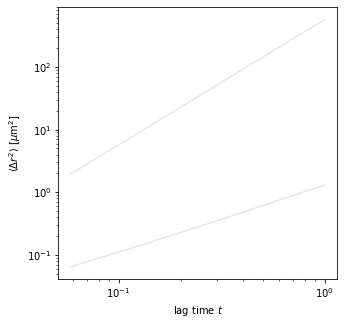

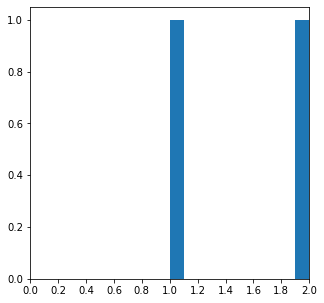

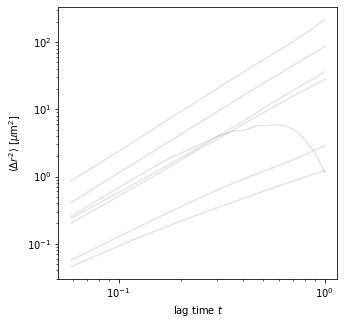

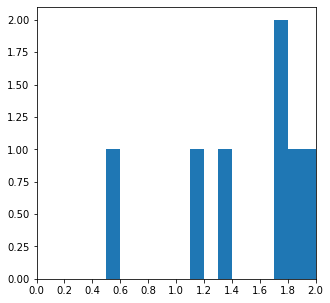

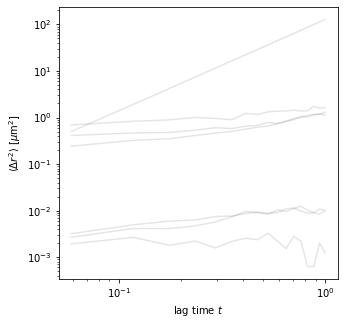

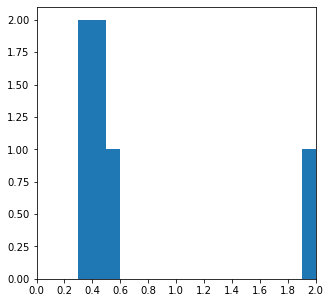

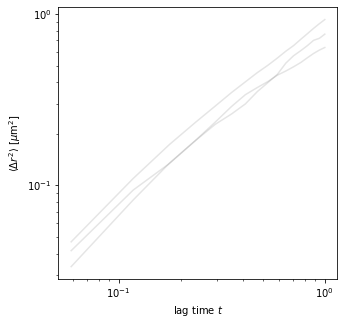

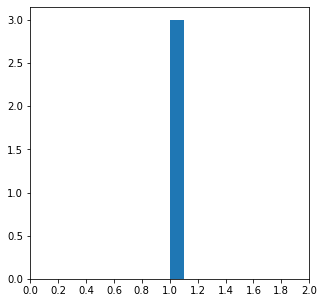

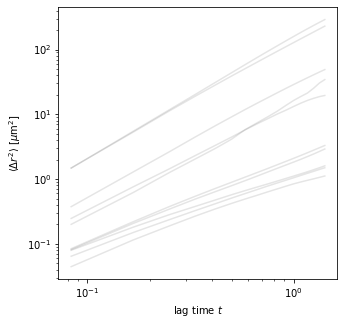

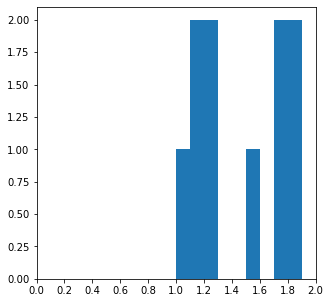

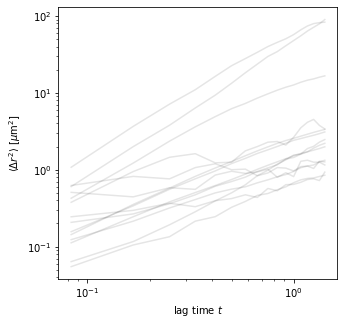

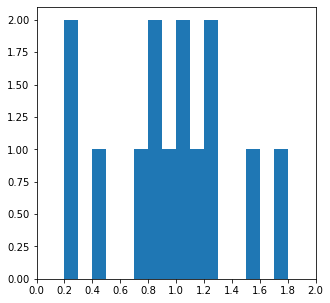

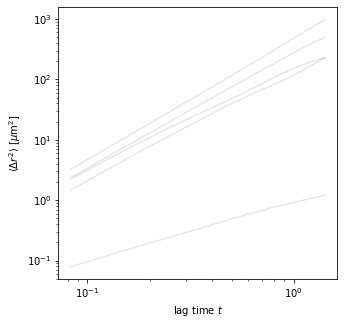

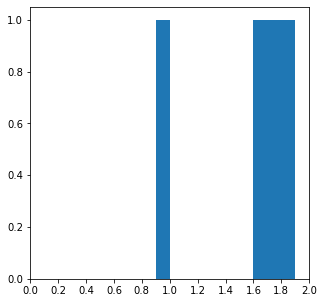

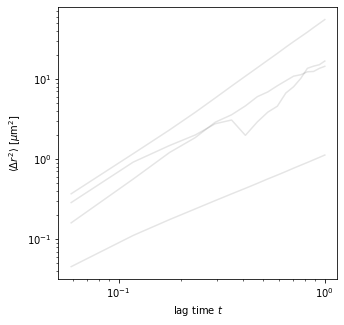

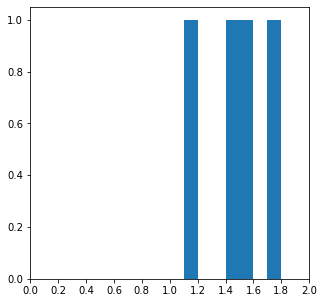

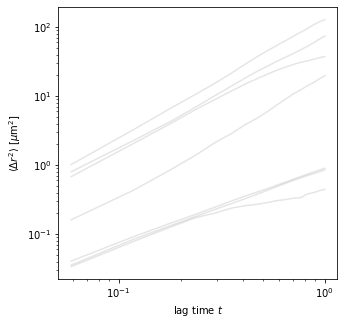

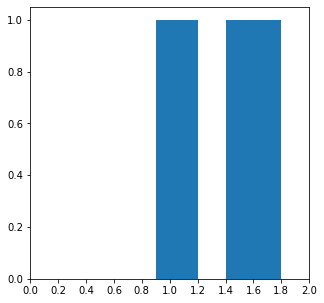

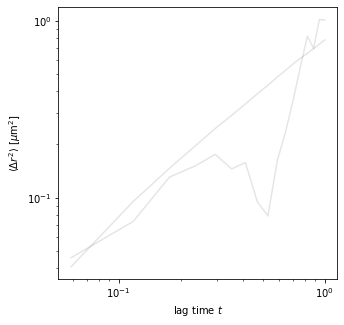

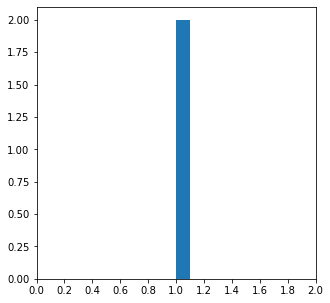

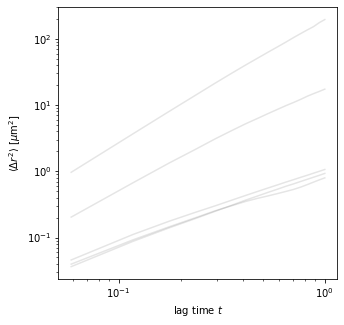

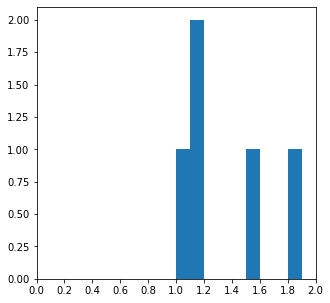

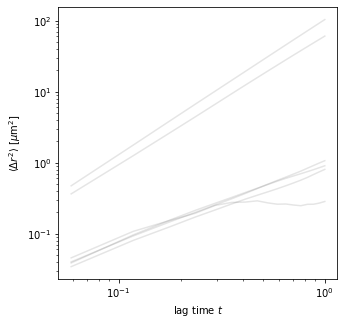

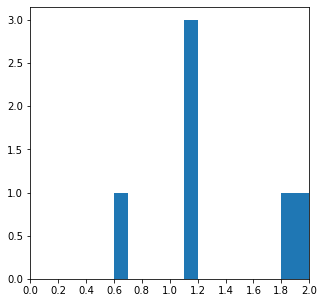

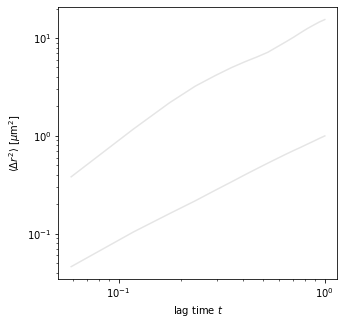

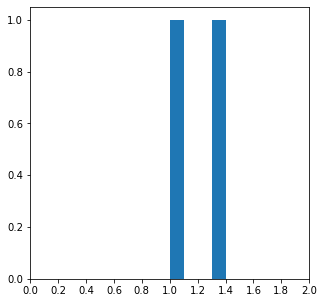

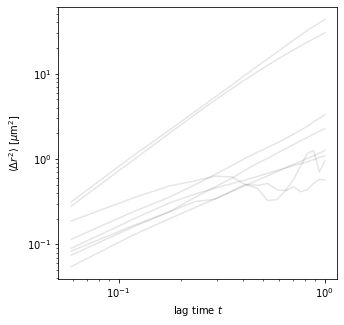

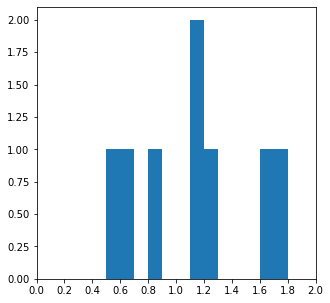

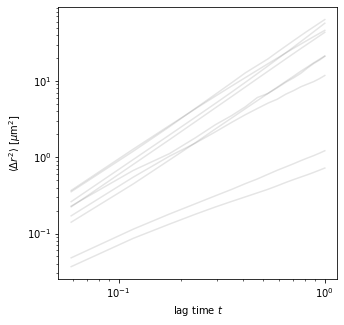

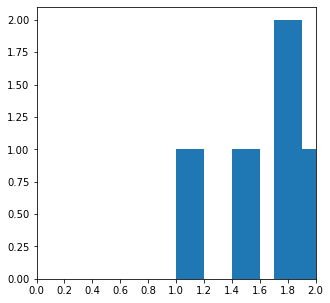

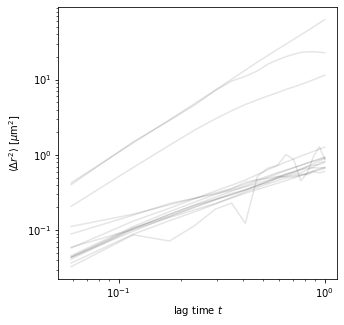

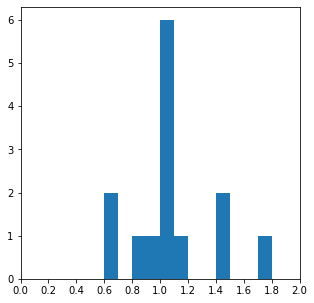

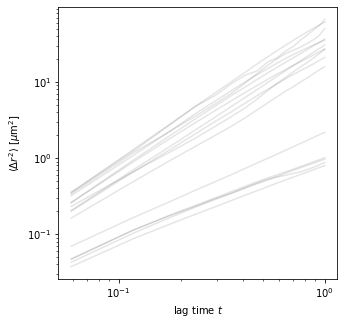

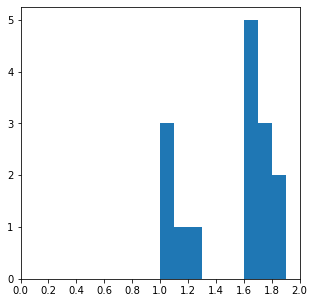

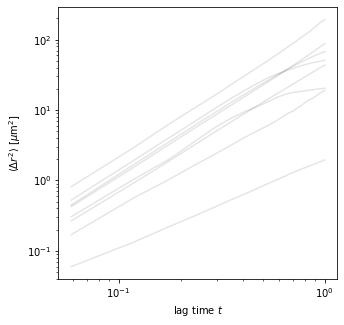

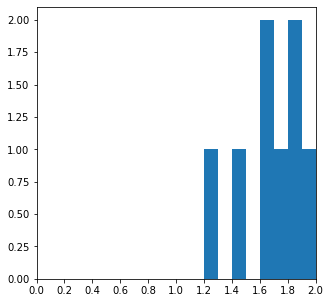

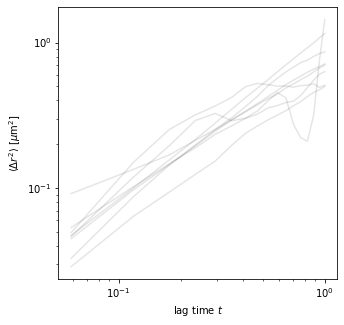

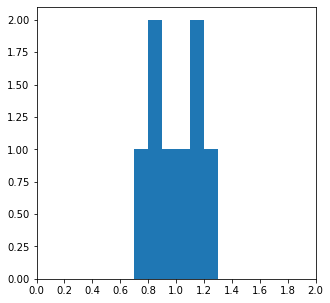

In [10]:
os.chdir(DATR_f_path) # set the working directory to the DATA_TRAJ_filter folder
fl_DATA = os.listdir(DATR_f_path)# create a list of all filenames
te = 120 # time of recording in seconds, all videos recorded in the enounter rate experiments were 120 seconds in length
l_t = 17 # maximum lag time in frames (this corresponds more or less to 1 second)
i = 1 # step variable
pmc = 3.076923 # pixels per micrometer conversion factor
d_Dtot = pd.DataFrame() # create an ampty DataFrame
for value in fl_DATA: # for loop that will cycle through each .csv-file
    os.chdir(DATR_f_path)# set the working directory to the DATA_TRAJ_filter folder
    trf = pd.read_csv(value) # import the .csv file as a DataFrame
    fr = trf["frame"].max() + 1 # calculate the total amount of frames for this timepoint, due to the nature of recording longer timelapses the total amount of frames in betwene timepoints could differ slightly
    fr_ps = round(fr/te) # calculate the fps for this given timepoint
    msd = tp.imsd(trf, 1/pmc, fps = fr_ps, max_lagtime = l_t) # calculate the MSD of each trajectory
    os.chdir(DATR_MSD_path) # set the working directory to the DATR_MSD filter folder
    filename_msd = value.replace('.csv', '_msd.csv') # create a new filename
    pd.DataFrame(msd).to_csv(filename_msd) # save the MSD DataFrame as a .csv file
    ## plot figure off all MSD's
    plt.figure(figsize = (5,5)) # create an empty plot
    ax_msd = plt.subplot(1,1,1) # add axes to the plot
    ax_msd.plot(msd.index, msd, 'k-', alpha=0.1) # plot the MSD's
    ax_msd.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$') # label the axes
    ax_msd.set_xscale('log') # rescale the x-axis to logarithmic
    ax_msd.set_yscale('log') # rescale the y-axis to logarithmic
    plotname_msd = value.replace('.csv', '_MSD.tif') # create a new plotname
    os.chdir(FIGmsd_path) # set the working directory to the FIG_MSD folder
    plt.savefig(plotname_msd, format = 'tif', dpi = 600) # save the MSD plot 
    ## calculate the translational component for filtering purposes
    msdt = msd.transpose() # transposed the DataFrame to calculate the translational component
    msdt.drop(msdt.loc[msdt[1.0]== 0].index, inplace=True)
    msdt['tc'] = ((np.log10(msdt[l_t/fr_ps]) - np.log10(msdt[1/fr_ps]))/(np.log10(l_t/fr_ps)-np.log10(1/fr_ps))) # calculate the translational component based on the MSD curves
    os.chdir(DATR_MSD_TC_path) # set the working directory to the DATR_MSD_TC folder
    filename_tc = value.replace('.csv', '_tc.csv') # create a new filename
    pd.DataFrame(msdt).to_csv(filename_tc) # save the msdt DataFrame including tc data as a .csv file
    ## plot a histogram of translational component
    plt.figure(figsize = (5,5)) # create an empty plot
    ax_tc = plt.subplot(1,1,1) # add axes to the plot
    ax_tc.set_xlim([0,2]) # set the x-axis limit
    plt.xticks(np.arange(0, 2.2, 0.2)) # set the x-axis ticks
    plt.hist(msdt['tc'], bins = np.arange(0,2.1, 0.1)) # plot a histogram of tc data
    plotname = value.replace('.csv', '_tc.tif') # create a new plotname
    os.chdir(FIG_TC_path) # set the working directory to the FIG_TC folder
    plt.savefig(plotname, format = 'tif', dpi = 300) # save the tc plot 
    print(i, 'out of', len(fl_DATA), ' files have been analyzed for msd and tc')
    i += 1


<h4>Filter out trajectories that are subdiffusive based on their translational component</h4>

1 out of 59  files have been msd filtered for non-motile bacteria
2 out of 59  files have been msd filtered for non-motile bacteria
3 out of 59  files have been msd filtered for non-motile bacteria
4 out of 59  files have been msd filtered for non-motile bacteria
5 out of 59  files have been msd filtered for non-motile bacteria
6 out of 59  files have been msd filtered for non-motile bacteria
7 out of 59  files have been msd filtered for non-motile bacteria
8 out of 59  files have been msd filtered for non-motile bacteria
9 out of 59  files have been msd filtered for non-motile bacteria
10 out of 59  files have been msd filtered for non-motile bacteria
11 out of 59  files have been msd filtered for non-motile bacteria
12 out of 59  files have been msd filtered for non-motile bacteria
13 out of 59  files have been msd filtered for non-motile bacteria
14 out of 59  files have been msd filtered for non-motile bacteria
15 out of 59  files have been msd filtered for non-motile bacteria
16 o

C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


22 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


23 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


24 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


25 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


26 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


27 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


28 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


29 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


30 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


31 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


32 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


33 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


34 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


35 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


36 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


37 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


38 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


39 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


40 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


41 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


42 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


43 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


44 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


45 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


46 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


47 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


48 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


49 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


50 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


51 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


52 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


53 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


54 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


55 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


56 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


57 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


58 out of 59  files have been msd filtered for non-motile bacteria


C:\Users\DeSchaetzen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


59 out of 59  files have been msd filtered for non-motile bacteria


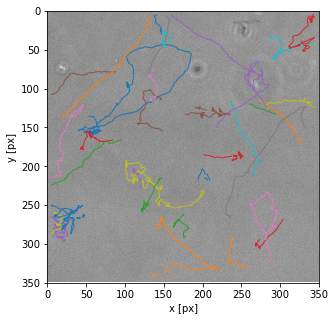

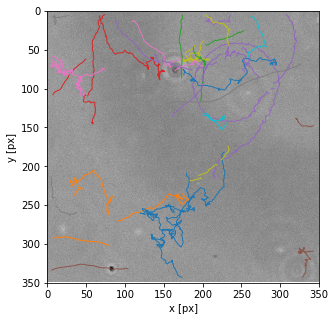

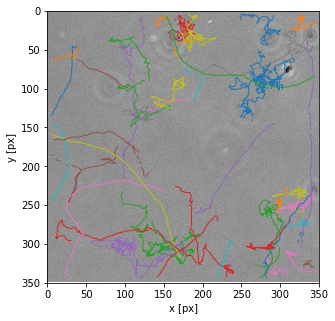

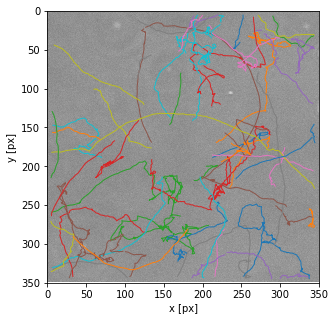

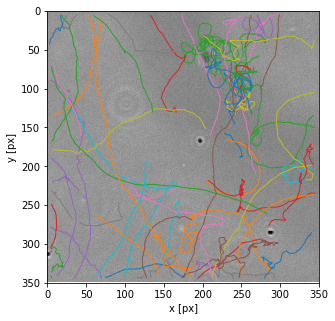

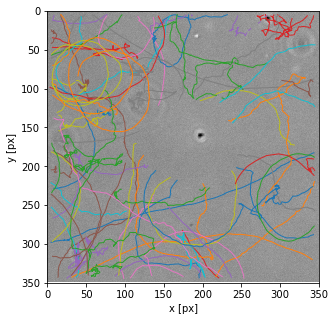

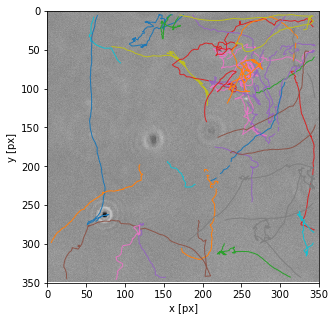

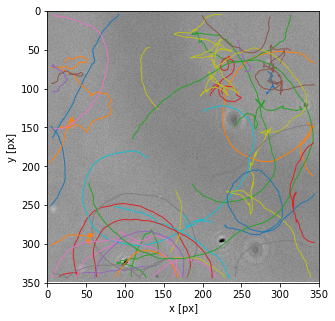

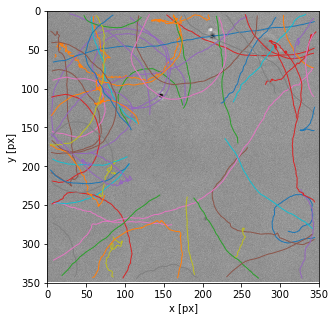

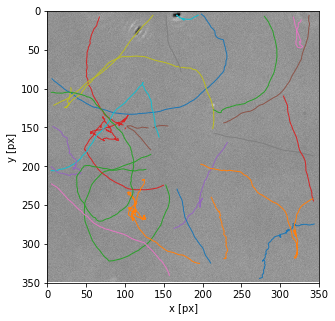

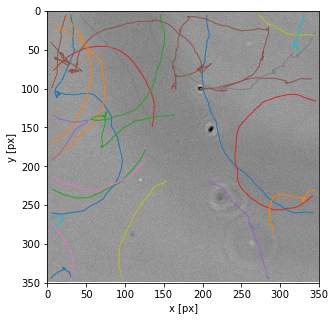

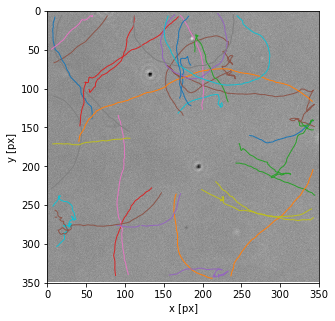

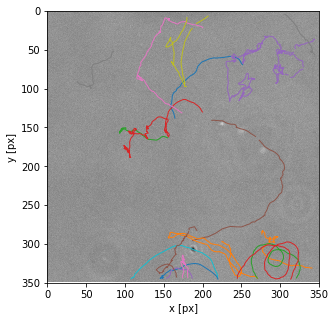

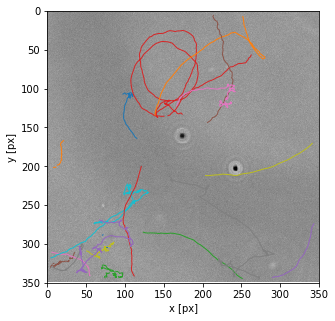

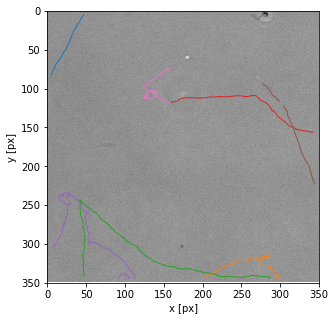

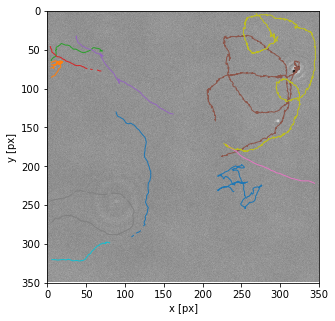

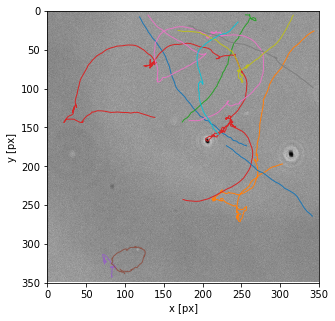

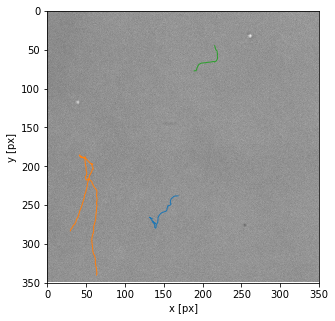

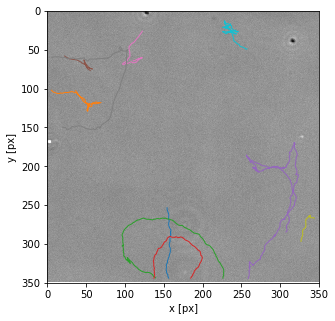

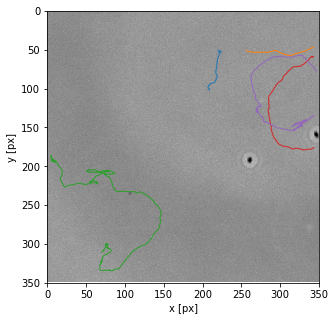

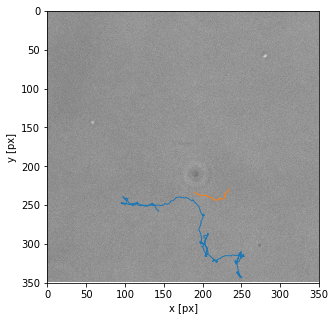

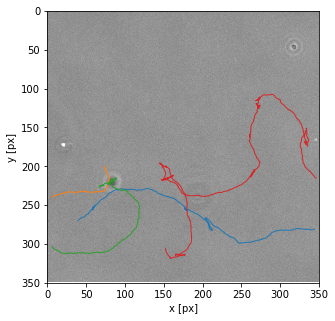

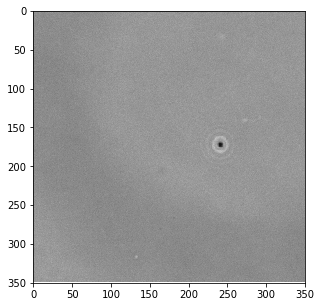

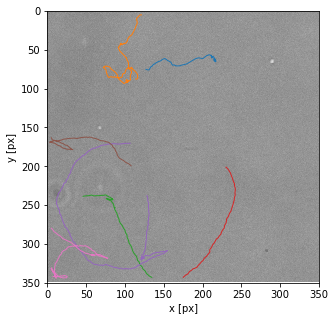

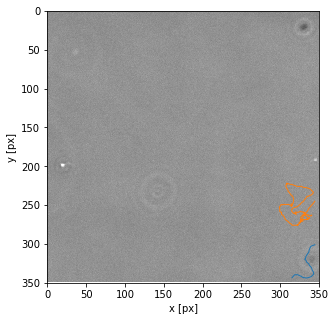

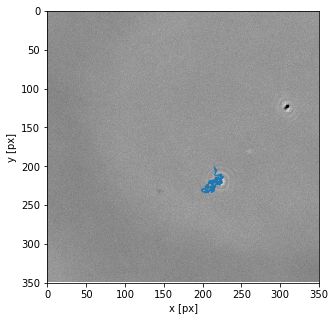

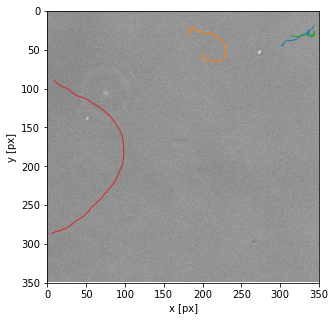

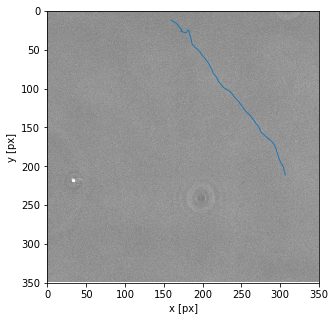

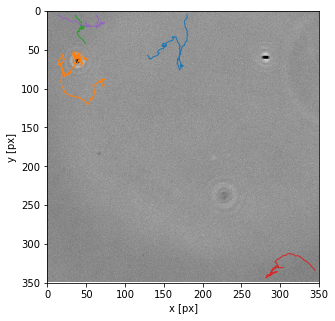

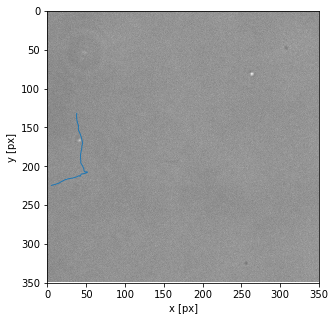

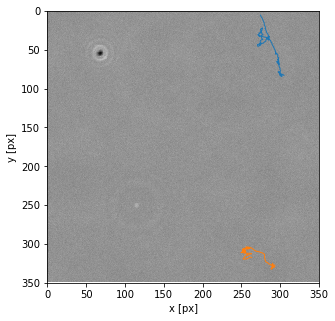

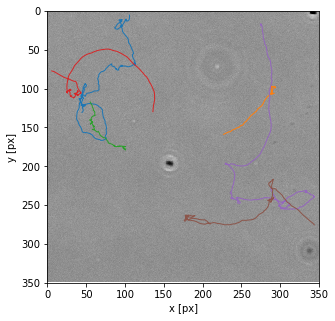

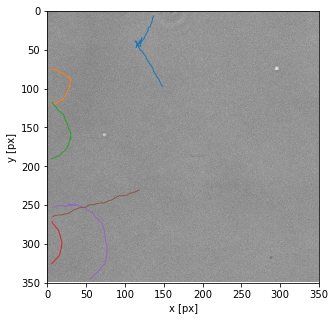

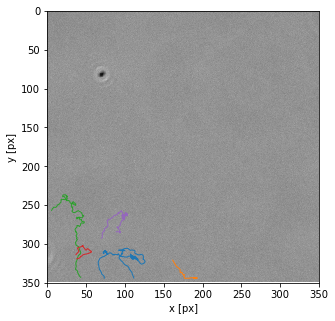

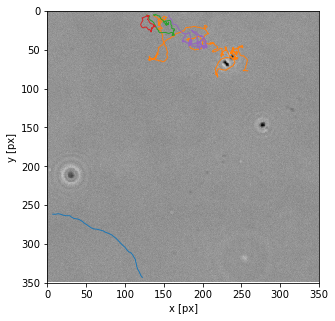

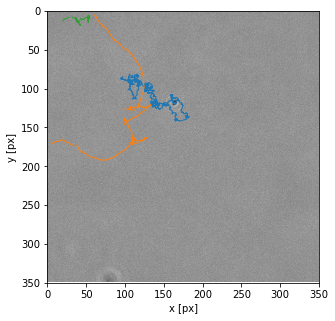

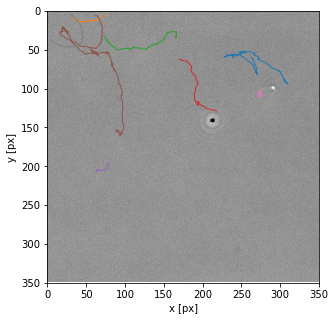

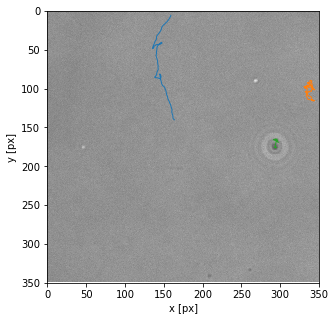

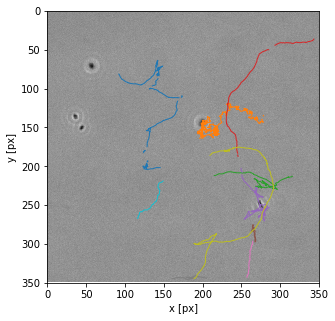

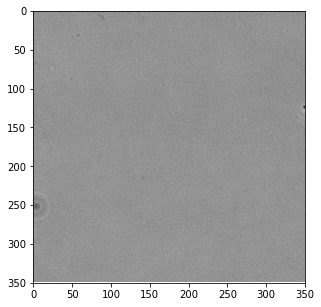

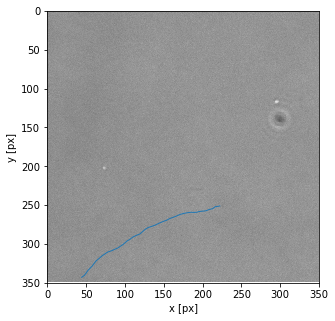

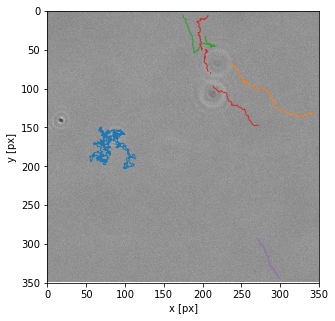

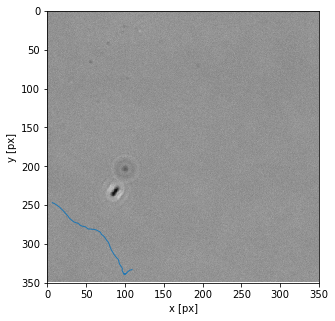

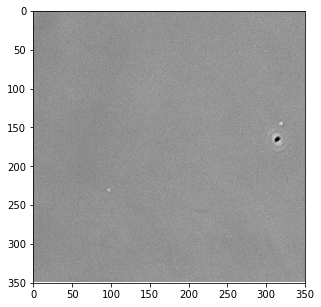

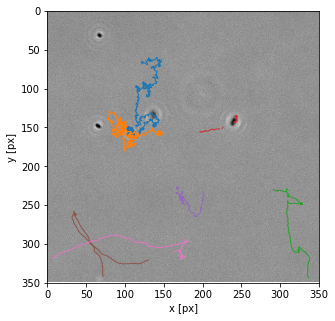

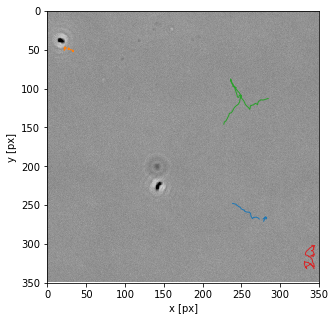

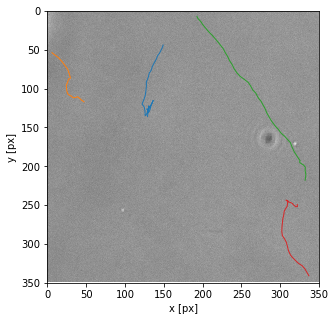

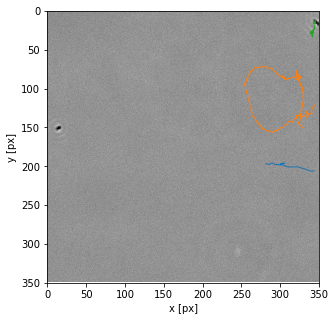

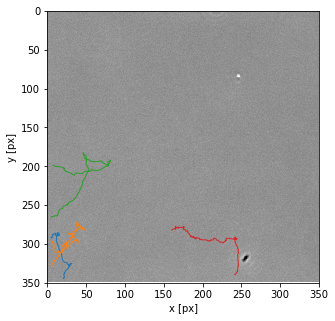

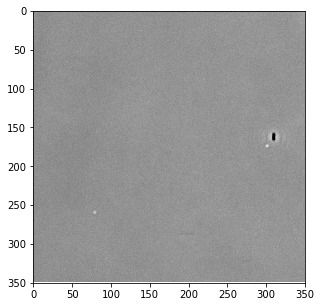

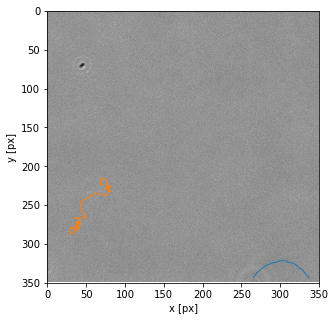

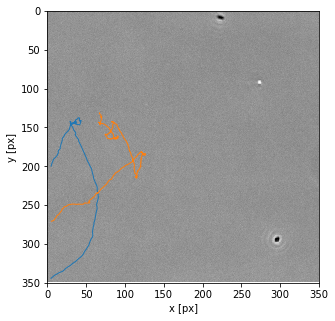

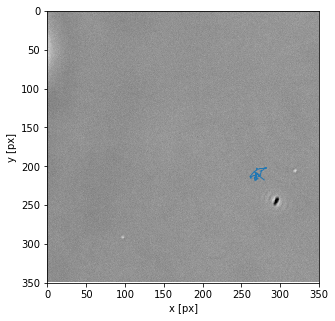

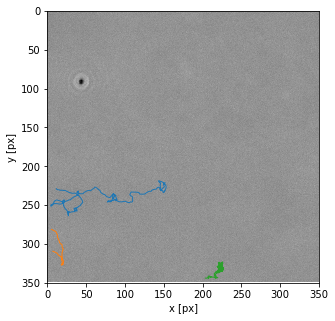

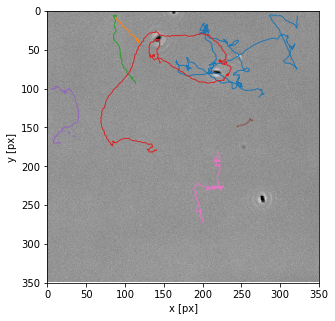

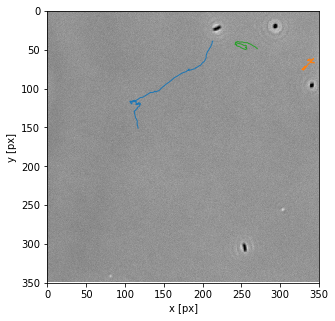

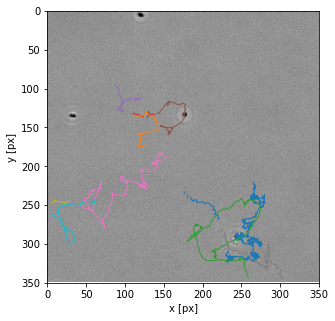

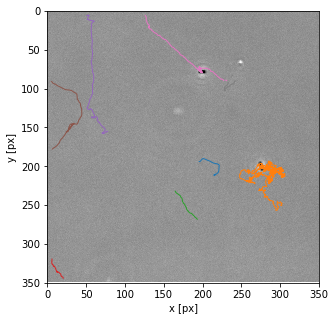

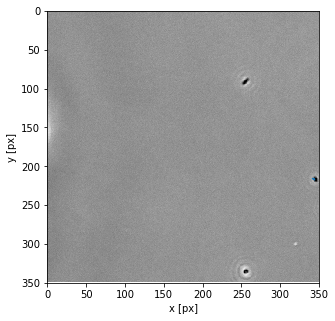

In [11]:
os.chdir(DATR_MSD_TC_path) # set the working directory to the DATR_MSD_KT folder
fl_DATR_MSD_TC = os.listdir(DATR_MSD_TC_path) # create a list of all filenames
co_tc = 1.2 # cutoff value for tc
i = 1 # step variable
for Value in fl_DATR_MSD_TC:  # for loop that will cycle through each .csv-file
    os.chdir(SCALE_path) # set the working directory to the DATR_MSD_KT folder
    filename_frames = os.path.splitext(Value[0:4])[0] + "_scaled.tif"
    frames = np.array(imread(filename_frames)) # import the frames as a numpy array
    xlim = int(frames.shape[2]) # retrieve the width of the videofile for plotting purposes
    ylim = int(frames.shape[1]) # retrieve the height of the videofile for plotting purposes
    ## create a list of particles with their unique ID that have a translational component larger or equal than 1.2
    os.chdir(DATR_MSD_TC_path) # set the working directory to the DATR_MSD_TC folder
    msdt_tc = pd.read_csv(Value, index_col = 0) # import the .csv file as a DataFrame
    msdt_tc = msdt_tc.loc[msdt_tc['tc'] >= co_tc] # filter out particles that are not-motile/subdiffusive
    dpart =  list(msdt_tc.index.values) # make a list of all particles that are considered to be motile
    filename_fe = Value.replace('_tc.csv', '.csv') # create a filename to call on a previously made trajectory .csv file
    os.chdir(DATR_f_path) # set the working directory to the DATR_f folder
    trf = pd.read_csv(filename_fe) # import the .csv file as a DataFrame
    ## filter out all bacteria that did not meet the cut-off value
    trf = trf.loc[trf['particle'].isin(dpart)] #filter out particles that have a tc value lower or equal than 1.2
    os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
    filename_trf = filename_fe.replace('.csv', '_MSDfilter.csv') # create a new filename
    pd.DataFrame(trf).to_csv(filename_trf) # save the filtered trajectory Dataframe to a .csv file
    ## plot the filtered trajectories
    plt.figure(figsize = (5,5)) # create an empty plot
    ax1 = plt.subplot(1,1,1) # add axes to the plot
    ax1.set_xlim([0,xlim]) # set the x-axis limit
    ax1.set_ylim([ylim,0]) # set the y-axis limit
    plt.imshow(frames[int(len(frames)/2)], cmap = 'Greys_r' , vmin = 0, vmax = 255) # add the middle frame as a background image 
    if len(trf) == 0:
        plotname = Value.replace('.csv', '_MSD_traj.tif') # create a new plotname
        os.chdir(FIG_MSD_traj_path) # set the working directory to the FIG_MSD_traj folder
        plt.savefig(plotname, format = 'tif', dpi = 300) # save the plot as a .tif file
    else: 
        tp.plot_traj(trf, ax=ax1,colorby = 'particle') # plot the trajectories
        plotname = Value.replace('.csv', '_MSD_traj.tif') # create a new plotname
        os.chdir(FIG_MSD_traj_path) # set the working directory to the FIG_MSD_traj folder
        plt.savefig(plotname, format = 'tif', dpi = 300) # save the plot as a .tif file
    print(i, 'out of', len(fl_DATR_MSD_TC), ' files have been msd filtered for non-motile bacteria')
    i += 1    

<h4>Count Listeria cells entering and leaving the interaction zone</h4>

This script block allowed us to calculate the number of captured Listeria cells per Amoeba and per time point. 

In [13]:
os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
fl_DATR_MSD_f = os.listdir(DATR_MSD_f_path) # create a list of all filenames
counts = pd.DataFrame(columns = ['time','amoeba_label', 'in', 'out', 'cap', 'capcor', 'in_small', 'out_small', 'cap_small' , 'capcor_small']) # create an empty DataFrame with the appropriate headers
i = 1 # step variable
for value in fl_DATR_MSD_f: # for loop that will cycle through each .csv-file
    os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
    trf = pd.read_csv(value, index_col = 0) # import the .csv file as a DataFrame
    mask = [] # create an empty list
    mask_small = [] # create an empty list
    # Analysis with the NORMAL interaction mask
    os.chdir(CANNY_INTERACTION_path) # set the working directory to the CANNY_INTERACTION folder
    filename_interaction = os.path.splitext(value[0:4])[0] + "_interaction.tif" # create a filename to call on the correct interaction mask file
    frames_interaction = np.array(imread(filename_interaction))  # import the interaction mask file as a numpy array
    # Analysis with the SMALL interaction mask (uncomment the next two rows if )
    os.chdir(CANNY_INTERACTION_small_path) # set the working directory to the CANNY_INTERACTION_small folder
    filename_interaction_small = os.path.splitext(value[0:4])[0] + "_interaction_small.tif" # create a filename to call on the correct small interaction mask file
    frames_interaction_small = np.array(imread(filename_interaction_small))  # import the interaction mask file as a numpy array
    for f in trf['frame.1'].unique(): # for loop that cycles through each frame
        frame_data = trf.loc[trf['frame.1'] == f] # select feature data for given frame f
        frame_interaction = frames_interaction[f,::] # select frame mask f
        frame_index = list(frame_data[["y", "x"]].round().astype(int).itertuples(index=False, name=None)) # get list of coordinates of features within frame (rounded upwards and transformed to integer for use in numpy)
        frame_mask = np.array([frame_interaction[b] for b in frame_index]) # returns either 0 (outside) or 255 (within) amoeba area
        mask.extend(frame_mask) # append into mask list
        frame_interaction_small = frames_interaction_small[f,::] # select frame mask f    
        frame_mask_small = np.array([frame_interaction_small[c] for c in frame_index]) # returns either 0 (outside) or 255 (within) amoeba area
        mask_small.extend(frame_mask_small) # append into mask list
    mask = np.array(mask) # convert from list to numpy array
    mask[mask == 255] = 1 # change all 255 cell values to 1
    trf['mask'] = mask # add a collumn with the mask values to the trajectories DataFrame
    mask_small = np.array(mask_small) # convert from list to numpy array
    mask_small[mask_small == 255] = 1 # change all 255 cell values to 1
    trf['mask_small'] = mask_small # add a collumn with the mask values to the trajectories DataFrame
    difference = [] # create an ampty list
    difference_small = [] # create an ampty list
    for p in trf.particle.unique(): # for loop that cycles through each unique particle ID
        particle_data = trf.loc[trf['particle'] == p] # select all data corresponding to the respective particle ID
        end = (len(particle_data['mask']) - 1) # determine the second to last cell position that has a mask value for a given particle
        mask_0end = np.array(particle_data['mask'].iloc[0:end], dtype = int) # create a numpy array with all mask values from position 0 to value end
        mask_1end = np.array(particle_data['mask'].iloc[1:], dtype = int) # create a numpy array with all mask values from position 1 
        sub_difference = np.array(mask_0end - mask_1end) # by taking the difference from the two previous numpy array we know when a cell entered the interaction mask (= -1) or exited the interaction mask (= 1)
        difference.extend(sub_difference) # append the difference values into a list
        end_small = (len(particle_data['mask_small']) - 1) # determine the second to last cell position that has a mask value
        mask_small_0end = np.array(particle_data['mask_small'].iloc[0:end_small], dtype = int) # create a numpy array with all mask values from position 0 to value end
        mask_small_1end = np.array(particle_data['mask_small'].iloc[1:], dtype = int) # create a numpy array with all mask values from position 1 
        sub_difference_small = np.array(mask_small_0end - mask_small_1end) # by taking the difference from the two previous numpy array we know when a cell entered the interaction mask (= -1) or exited the interaction mask (= 1)
        difference_small.extend(sub_difference_small) # append the difference values into a list
    difference = np.array(difference) # convert from list to numpy array
    difference_small = np.array(difference_small) # convert from list to numpy array
    timepoint = int(value[0:2]) # collect the time point from the file ame
    amoeba_label = value[3] # collect the amoeba-label from the filename
    ins = np.count_nonzero(difference == -1) # count the amount of Listeria that entered the interaction mask
    outs = np.count_nonzero(difference == 1) # count the amount of Listeria that exited the interaction mask
    cap = ins - outs # calculate the amount of captured Listeria cells
    capcor = cap*1.5 # this correction is made to account for the 1 minute gaps in between each 2 mins recording
    ins_small = np.count_nonzero(difference_small == -1) # count the amount of Listeria that entered the interaction mask
    outs_small = np.count_nonzero(difference_small == 1) # count the amount of Listeria that exited the interaction mask
    cap_small = ins_small - outs_small # calculate the amount of captured Listeria cells
    capcor_small = cap_small*1.5 # this correction is made to account for the 1 minute gaps in between each 2 mins recording
    values = [(timepoint, amoeba_label, ins, outs, cap, capcor, ins_small, outs_small, cap_small, capcor_small)] # make list of all values
    sub_counts = pd.DataFrame(values ,columns = ['time','amoeba_label', 'in', 'out', 'cap' , 'capcor', 'in_small', 'out_small', 'cap_small' , 'capcor_small']) # creata a DataFrame row with all values
    counts = counts.append(sub_counts, sort = False) # collect all rows into one DataFrame
    print(i,'out of', len(fl_DATR_MSD_f), ' files have been analyzed for capture counts')
    i += 1;
os.chdir(OUTPUT_path)  # set the working directory to the OUTPUT folder
counts.to_csv('capture_counts.csv')  # save the counts DataFrame as a .csv file

1 out of 59  files have been analyzed for capture counts
2 out of 59  files have been analyzed for capture counts
3 out of 59  files have been analyzed for capture counts
4 out of 59  files have been analyzed for capture counts
5 out of 59  files have been analyzed for capture counts
6 out of 59  files have been analyzed for capture counts
7 out of 59  files have been analyzed for capture counts
8 out of 59  files have been analyzed for capture counts
9 out of 59  files have been analyzed for capture counts
10 out of 59  files have been analyzed for capture counts
11 out of 59  files have been analyzed for capture counts
12 out of 59  files have been analyzed for capture counts
13 out of 59  files have been analyzed for capture counts
14 out of 59  files have been analyzed for capture counts
15 out of 59  files have been analyzed for capture counts
16 out of 59  files have been analyzed for capture counts
17 out of 59  files have been analyzed for capture counts
18 out of 59  files hav

<h4>Calculate the Listeria density around each Acanthamoeba</h4>

In [14]:
os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
fl_DATR_MSD_f = os.listdir(DATR_MSD_f_path) # create a list of all filenames
os.chdir(OUTPUT_path) # set the working directory to the OUTPUT folder
amoeba_size = pd.read_csv('amoeba_size.csv') # import the amoeba_size .csv file
density = pd.DataFrame(columns = ['time','amoeba_label', 'traj_tot', 'traj', 'traj_std', 'traj_dens', 'traj_std_dens', 'trajf_tot', 'trajf', 'trajf_std', 'trajf_dens', 'trajf_std_dens']) # create an empty DataFrame with the correct collumn headers
i = 1 # step variable
xylim = 350 # width and height of the videos in pixels
pmc = 3.076923 # pixel per micrometer conversion factor (this was determined by the microscope and remained constant for all encounter rate experiments, since they were all performed on one microscope with constant paramters)
xylim_um = xylim/pmc # width and height of the videos in micrometers
dof = 10 # this is the assumed depth of field (in micrometer) over which we are detecting and tracking listeria cells
for value in fl_DATR_MSD_f:  # for loop that will cycle through each .csv-file
    timepoint = int(value[0:2]) # collect the time point from the filename
    amoeba_label = value[3] # collect the amoeba-label from the filename
    amoeba_area = amoeba_size.loc[(amoeba_size['time'] == timepoint) & (amoeba_size['amoeba_label'] == str(amoeba_label)), 'area_amoeba'].values[0] # get the area of the amoeba, based on the amoeba mask, for the corresponding time point and amoeba label
    density_volume = dof*((xylim_um*xylim_um) - amoeba_area) # this is the volume component with which the trajectory counts will be divided to get a cells/micrometer^3 Listeria density                                                               
    os.chdir(DATR_path) # set the working directory to the DATR folder
    filename_traj = os.path.splitext(value[0:4])[0] + "_traj.csv" # create the corresponding trajectory .csv filename
    tr = pd.read_csv(filename_traj) # import the trajectory .csv file as a DataFrame
    traj_tot = tr['particle'].nunique() # retrieve total number of unique trajectories based on particle ID for the complete time point
    traj = np.mean(tr['frame'].value_counts()) # calculate the average number of trajectories per frame
    traj_std = np.std(tr['frame'].value_counts()) # calculate the standard deviation of the number of trajectories per frame
    traj_dens = traj/density_volume # transform the average number of trajectories per frame into a density
    traj_std_dens = traj_std/density_volume # transform the standard deviation of the number of trajectories per frame into a density                                                                   
    os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
    trf = pd.read_csv(value) # import the MSD filtered trajectory .csv file as a DataFrame
    trajf_tot = trf['particle'].nunique() # retrieve total number of unique MSD filtered trajectories based on particle ID for the complete time point
    trajf = np.mean(trf['frame'].value_counts()) # calculate the average number of MSD filtered trajectories per frame
    trajf_std = np.std(trf['frame'].value_counts())  # calculate the standard deviation of the number of MSD filtered trajectories per frame
    trajf_dens = trajf/density_volume # transform the average number of MSD filtered trajectories per frame into a density
    trajf_std_dens = trajf_std/density_volume # transform the standard deviation of the number of MSD filtered trajectories per frame into a density                                                                   
    values = [(timepoint, amoeba_label, traj_tot, traj, traj_std, traj_dens, traj_std_dens, trajf_tot, trajf, trajf_std, trajf_dens, trajf_std_dens)] # collect all parameters into a list
    subdensity = pd.DataFrame(values, columns = ['time','amoeba_label', 'traj_tot', 'traj', 'traj_std', 'traj_dens', 'traj_std_dens', 'trajf_tot', 'trajf', 'trajf_std', 'trajf_dens', 'trajf_std_dens']) # creata a DataFrame row from all parameters 
    density = density.append(subdensity, sort = False) # colect all rows into one DataFrame
    print(i,'out of', len(fl_DATR_MSD_f), ' files have been analyzed for density parameters')
    i += 1;
os.chdir(OUTPUT_path) # set the working directory to the OUTPUT folder
density.to_csv('density.csv') # save the density DataFrame as a .csv file

1 out of 59  files have been analyzed for density parameters
2 out of 59  files have been analyzed for density parameters
3 out of 59  files have been analyzed for density parameters
4 out of 59  files have been analyzed for density parameters
5 out of 59  files have been analyzed for density parameters
6 out of 59  files have been analyzed for density parameters
7 out of 59  files have been analyzed for density parameters
8 out of 59  files have been analyzed for density parameters
9 out of 59  files have been analyzed for density parameters
10 out of 59  files have been analyzed for density parameters
11 out of 59  files have been analyzed for density parameters
12 out of 59  files have been analyzed for density parameters
13 out of 59  files have been analyzed for density parameters
14 out of 59  files have been analyzed for density parameters
15 out of 59  files have been analyzed for density parameters
16 out of 59  files have been analyzed for density parameters
17 out of 59  fil

<h4>Calculate Listeria swimming speeds</h4>

In [16]:
os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
FL_DATR_MSD_f = os.listdir(DATR_MSD_f_path) # create a list of all filenames
te = 120 # total time of the video in seconds
pmc = 3.076923 # pixel per micrometer conversion factor (this was determined by the microscope and remained constant for all encounter rate experiments, since they were all performed on one microscope with constant paramters)
i = 1 # step variable
v_tot = pd.DataFrame() # creata an empty DataFrame
for Value in FL_DATR_MSD_f: # for loop that will cycle through each .csv-file
    os.chdir(DATR_MSD_f_path) # set the working directory to the DATR_MSD_f folder
    trf = pd.read_csv(Value) # import the MSD filtered trajectory .csv file as a DataFrame
    if len(trf) == 0:
        continue
    else:
        tot_frame = trf['frame'].max()+1 # determine the total amount of frames, the +1 modifier is to account for the initial frame value of 0
        fps = round((tot_frame + 1)/te) # average frames per second based on the total frames divided by the total time of each video
        part_id = pd.DataFrame(trf.particle.unique(), columns = ['pID']) # creata a list of all unique particle Id's
        #mp = part_id.pID.nunique()
        d = pd.DataFrame() # creata an empty DataFrame
        v_data = pd.DataFrame(columns = ['time', 'amoeba_label', 'v_mean', 'v_std', 'pID']) # create an empty DataFrame
        timepoint = int(Value[0:2]) # collect the time point from the filename
        amoeba_label = Value[3] # collect the amoeba-label from the filename
        for p in set(trf.particle): # for loop that cycles through each unique particle ID
            p_data = trf[trf.particle == p] # select all data from the MSD filtered trajectory DataFrame for a given particle ID
            dx = np.diff(p_data.x)/pmc # calculate the difference between consecutive x-coordinates
            dy = np.diff(p_data.y)/pmc # calculate the difference between consecutive y-coordinates
            #if fps == 0: # if else function in case 
            #    v = 0
            #else:
            v = (np.sqrt(dx**2+dy**2)/np.diff(p_data.frame))*fps # calculate the swimming speed between each recorded coordinate by caulculated the pythagorean distance divided by the number of frames between each consecutive coordinated, multiplied by the frames per second 
            v_mean = np.mean(v) # calculate the mean swimming speed
            v_std = np.std(v)
            values = [(timepoint, amoeba_label, v_mean, v_std, p)] # create a list of all calculated parameters
            sub_v_data = pd.DataFrame(values, columns = ['time', 'amoeba_label', 'v_mean', 'v_std', 'pID']) # creata a DataFrame row from all parameters 
            v_data = v_data.append(sub_v_data, sort = False) # collect all rows into one DataFrame
    # save this dataframe as a csv
    print(i, 'out of', len(FL_DATR_MSD_f), ' files have been analyzed for Listeria swimming speeds')
    i += 1
    v_tot = pd.concat((v_tot, v_data), axis=0) # combine all DataFrames into one
# Average swimming speeds for each Amoeba or for each timepoint
v_amoeba = pd.DataFrame() # creata an empty DataFrame
v_time = pd. DataFrame() # creata an empty DataFrame
time_list = list(np.unique(v_tot.time)) # create a list of each timepoint
for t in time_list: # for loop that will cycle through each timepoint
    v_tot_t = v_tot[v_tot.time == t] # select all data from the swimming speed DataFrame for a given timepoint
    v_mean_t = np.mean(v_tot_t.v_mean) # calculate the mean swimming speed
    v_std_t = np.std(v_tot_t.v_mean) # calculate the standard deviation of the swimming speed
    values_t = [(t , v_mean_t, v_std_t)] # create a list of all calculated parameters
    v_time_sub = pd.DataFrame(values_t, columns = ['time', 'v_mean', 'v_std'])  # creata a DataFrame row from all parameters 
    v_time = v_time.append(v_time_sub, sort = False) # collect all rows into one DataFrame
    amoeba_list = list(np.unique(v_tot_t.amoeba_label)) # create a list off all amoeba labels
    for a in amoeba_list: # for loop that will cycle through each amoeba label
        v_tot_t_a = v_tot_t[v_tot_t.amoeba_label == a] # select all data from the swimming speed for each timepoint DataFrame for a given timepoint
        v_mean_a = np.mean(v_tot_t_a.v_mean) # calculate the mean swimming speed
        v_std_a = np.std(v_tot_t_a.v_mean) # calculate the standard deviation of the swimming speed
        values_a = [(t , a, v_mean_a, v_std_a)] # create a list of all calculated parameters
        sub_v_amoeba = pd.DataFrame(values_a, columns = ['time', 'amoeba_label', 'v_mean', 'v_std'])  # creata a DataFrame row from all parameters 
        v_amoeba = v_amoeba.append(sub_v_amoeba, sort = False) # collect all rows into one DataFrame
os.chdir(OUTPUT_path) # set the working directory to the OUTPUT folder
pd.DataFrame(v_tot).to_csv('swimmingspeed_pt_pa_piD.csv') # save the mean swimming speed per time point, amoeba and particle ID Dataframe as a .csv file
v_amoeba.to_csv('swimmingspeed_pt_pa.csv')   # save the mean swimming speed per timepoint and amoeba Dataframe as a .csv file   
v_time.to_csv('swimmingspeed_pt.csv')  # save the mean swimming speed per time point Dataframe as a .csv file


1 out of 59  files have been analyzed for Listeria swimming speeds
2 out of 59  files have been analyzed for Listeria swimming speeds
3 out of 59  files have been analyzed for Listeria swimming speeds
4 out of 59  files have been analyzed for Listeria swimming speeds
5 out of 59  files have been analyzed for Listeria swimming speeds
6 out of 59  files have been analyzed for Listeria swimming speeds
7 out of 59  files have been analyzed for Listeria swimming speeds
8 out of 59  files have been analyzed for Listeria swimming speeds
9 out of 59  files have been analyzed for Listeria swimming speeds
10 out of 59  files have been analyzed for Listeria swimming speeds
11 out of 59  files have been analyzed for Listeria swimming speeds
12 out of 59  files have been analyzed for Listeria swimming speeds
13 out of 59  files have been analyzed for Listeria swimming speeds
14 out of 59  files have been analyzed for Listeria swimming speeds
15 out of 59  files have been analyzed for Listeria swimm

In [20]:
len(trf)

0

In [4]:
os.chdir(CANNY_INTERACTION_path)
fl_list = os.listdir(CANNY_INTERACTION_path)
# Absolute path of a file
for value in fl_list:
    old_name = value
    new_name = value.replace('_dilation.tif', '_interaction.tif')
    os.rename(old_name, new_name)


In [5]:
os.chdir(CANNY_INTERACTION_small_path)
fl_list = os.listdir(CANNY_INTERACTION_small_path)
# Absolute path of a file
for value in fl_list:
    old_name = value
    new_name = value.replace('_dilationsmall.tif', '_interaction_small.tif')
    os.rename(old_name, new_name)

In [6]:
os.chdir(CANNY_AMOEBA_path)
fl_list = os.listdir(CANNY_AMOEBA_path)
# Absolute path of a file
for value in fl_list:
    old_name = value
    new_name = value.replace('_erosion.tif', '_amoeba.tif')
    os.rename(old_name, new_name)

In [9]:
os.chdir(CANNY_INTERACTION_small_path)
fl_list = os.listdir(CANNY_INTERACTION_small_path)
# Absolute path of a file
for value in fl_list:
    old_name = value
    new_name = value.replace('_erosion.tif', '_interaction_small.tif')
    os.rename(old_name, new_name)

In [7]:
os.chdir(DATR_MSD_TC_path)
fl_list = os.listdir(DATR_MSD_TC_path)
# Absolute path of a file
for value in fl_list:
    old_name = value
    new_name = value.replace('_kt.csv', '_tc.csv')
    os.rename(old_name, new_name)

In [15]:
os.chdir(FIG_TC_path)
fl_list = os.listdir(FIG_TC_path)
# Absolute path of a file
for value in fl_list:
    old_name = value
    new_name = value.replace('_kt.tif', '_tc.tif')
    os.rename(old_name, new_name)

In [16]:
os.chdir(DATR_MSD_TC_path)
fl_list = os.listdir(DATR_MSD_TC_path)
for value in fl_list:
    trf = pd.read_csv(value)
    trf = trf.rename(columns={'kt': 'tc'})
    trf.to_csv(value)  # save the counts DataFrame as a .csv file